# Passenger Screening Algorithm Challenge
Camilo Ruiz, Ana-Maria Istrate.  
13 December 2017  

# 1. Introduction

## 1.1 Motivation

Every day, two million passengers board domestic flights in the United States. Before boarding a flight, each passenger must be scanned by a millimeter wave scanner (MWS). These scanners today must maximize both safety and efficiency. The inability to detect threats could jeopardize national security. Conversely, overly sensitive scanners can cause a high number of false positives. Passengers with suspected threats must undergo secondary screening. A high false positive rate, therefore, can incur massive airport delays especially when compounded over the 2M MWS scans conducted each day. The goal of this project is to design a Deep Learning architecture that (1) maximizes the detection rate of real threats in MWS scans while simultaneously (2) minimizing the false positive rate. 


## 1.2 Problem Statement and Data Set

To maximize the efficiency of secondary screening, a successful algorithm must take in an MWS scan and output the probability that a threat is present in each of 17 body zones (image below). For this project, we focused on predicting threats in the chest zone only (primarily because of challenge 1.4.3 below).

To solve this problem, we utilized an open dataset provided by the US Department of Homeland Security on Kaggle. The dataset is released in two stages. The first stage shares all of the images for training. The second stage will include a separate set of images for testing that participants cannot access. Only the first stage has been released and thus all description below is for the Stage I Dataset.  


### 1.2.1 Body Zones
** Table of Body Zones **
![Table of Body Zones](images/body_zone_descriptions.png)

** Image of Body Zones **
![Image of Body Zones](images/body_zone_image.png)

### 1.2.2 Stage I Dataset 

#### 1.2.2.1 Overview
The dataset contains MWS scans for 1,147 individuals. Each scan contains 17 labels, corresponding to whether or not a threat is present in each of 17 body zones. The dataset is balanced at the individual level: 219 individuals have no threats present in any of their body zones; 303, 307, and 318 individuals have 1, 2, and 3 threats present in any of their body zones respectively. However, the dataset is not balanced at the zone level: 1,871 zones have a threat present in them (9.6% of images) while 17,628 images do not have a threat present in them (90.4% of images). The code used to extract this information from the dataset is shown below.   

The full dataset can be downloaded at: https://www.kaggle.com/c/passenger-screening-algorithm-challenge/data. The specific .aps files we used can be downloaded at: https://www.kaggle.com/c/passenger-screening-algorithm-challenge/download/stage1_aps.tar.gz.

#### 1.2.2.2 Distribution
The Stage I Dataset was constructed by simulating real scanning conditions. Each scan contains variety in: gender, body mass index, number of threats, type of threats, and clothing type (light clothes to heavy clothes). This data was compiled to closely match the distribution of the Stage II Dataset, even though different individuals are in the Stage II dataset. 

#### 1.2.2.3 Image Formats
Each scan can be viewed in one of four formats, each explained below. All formats are simply different representations of the same 3D scan. 
0. ** Commonalities across formats **  All formats contain a 512 byte header file followed by the fileâ€™s data. The data is stored sequentially in order from the axis with the largest stride to the axis with the smallest stride. An AYX order would mean that the angular axis was the largest stride and consists of a series of YX planes incremented by angle.   
1. ** Projected Image Angle Sequence files ** (.aps; 10.3MB per file; AYX - angle, vertical axis, horizontal axis) represent a 3D image composed of a series of YX plans incremented by angle.   
2. ** Combined Image 3D files ** (.a3d; 330MB per file; YZX - height, depth axis, horizontal axis) consist of eight 3D images equally spaced around the scanned region compiled into one composite 3D image. The 3D image is stored in sequential height slices.  
3. ** Combined Image Angle Sequence File ** (.a3daps; 41.2MB per file; AYX - angle, vertical axis, horizontal axis) are generated from .a3d files. The resulting file is similar to .aps files, representing a 3D image sliced by angular slices.  
4. ** Calibrated Object Raw Data File ** (.ahi; 2.26GB per file; FXY - frequency, horizontal angular, vertical) files are raw data files. The remaining formats have been processed signals engineers to create images. Raw data points represent complex floating point words in frequency planes.

We experimented with various formats but ultimately decided to use the .aps file format. We primarily chose the .aps file format because it struck the right balance between (1) including all necessary infromation to learn from while (2) being the smallest file format available. In particular, note that there are 1147 files of each format. Thus the .aps files alone where ~12GB while the .a3daps files would have been ~50GB, the .a3d files would have been ~330GB, and the .ahi files would have been ~2.5TB. By keeping the file sizes as small as possible, we were able to maximize our iteration speed when testing different architectures.

#### 1.2.2.4 Sample Images of .aps files
##### 1.2.2.4.1 Images from Different Angles
The .aps files contained 16 different images for each subject, each representing a body scan taken from a specific angle. Below are sample angles for a single individual. Note that this individual has a threat in both the chest region and the back of the lower left calf.

<!---
![1](images/sample_image_threat_on_chest_2.png)
![2](images/sample_image_threat_on_chest_3.png)
![3](images/sample_image_threat_on_chest_4.png)
![4](images/sample_image_threat_on_chest_5.png)
![5](images/sample_image_threat_on_chest_6.png)
![7](images/sample_image_threat_on_chest_8.png)
![8](images/sample_image_threat_on_chest_9.png)
![9](images/sample_image_threat_on_chest_10.png)
![10](images/sample_image_threat_on_chest_11.png)
![11](images/sample_image_threat_on_chest_12.png)
![12](images/sample_image_threat_on_chest_13.png)
![13](images/sample_image_threat_on_chest_14.png)
![14](images/sample_image_threat_on_chest_15.png)
![15](images/sample_image_threat_on_chest_16.png)
-->


![0](images/sample_image_threat_on_chest.png)
![6](images/sample_image_threat_on_chest_7.png)


##### 1.2.2.4.2 Positive and Negative Image Examples
Examples of an individual with a threat on the chest and an individual without a threat on the chest are shown below. Notice that because of the relatively low resolution of the images it can be hard to distinguish whether or not a threat is present. It can even be difficult to distinguish the threat from similar patterns on "threat_free" regions of the body within the same individual. This is the root of one of our major challenges, explored below.

![0](images/sample_image_threat_on_chest.png)
![no_threat](images/sample_image_no_threat_on_chest.png)

## 1.3 Evaluation of the Models

### 1.3.1 Initial Loss
Consistent with the competition's metric, we initially evaluated our model on the basis of log loss. For $N$ images, we made a single prediction of the chest zone. Subsequently, we calculated the loss:
$$ Loss = \frac{-1}{N} \sum_{i = 1}^N [y_i log(\hat{y}_i) + (1-y_i) log(1-\hat{y}_i)] $$ where
- $N$ is 1*the number of scans in our data
- $y_i$ is the label for a zone, $1$ if a threat is present and $0$ otherwise
- $\hat{y}_i$ is the predicted label for a zone, $1$ if a threat is present and $0$ otherwise

### 1.3.2 Cross Weighted Loss
As we experimented, we realized that our model was underpredicting threats primarily due to class imbalance. As a result, we improved detection of threats by utilizing a cross weighted loss. 

$$ Loss = \frac{-1}{N} \sum_{i = 1}^N [\alpha y_i log(\hat{y}_i) + \alpha (1-y_i) log(1-\hat{y}_i)] $$ where the parameters are the same as above except $\alpha$ is a manually defined cost that increases the cost of failing to predict a threat.

### 1.3.3 Final Metrics
In addition to the loss, we were particularly interested in computing:  
1. Accuracy as an easily interpretable way of determining our performance.
2. Precision which determines the amount of true positives divided by true positives plus false positives. A low precision implies that the algorithm will incur significant travel delays by predicting too many false positives.
3. Recall which determines the number of true positives divided by true positives plus false positives.  

Of the three metrics, recall is the most important. A low recall implies that threats are being undetected which could substantially affect airport safety. A large portion of our subsequent experimentation was directed at improving recall. In the end, as discussed in the Experimentation Section, we chose to minimize recall such that the cross weighted loss also stayed below 0.20. 

### 1.3.4 Training, Validation, and Testing
We utilized an 80%/20% split between the training and testing set. Within the training set, we utilized an 80%/20% split between the training and validation set. 


## 1.4 Major Challenges
We identified three major challenges within this project.
### 1.4.1 Segmentation
The first major challenge was appropriately selecting and segmenting images. For each individual we have 16 total images at different angles. 

1. Not every angle shows every threat zones. For example, an image from the back does not allow you to detect images on the chest. To solve this issue, we manually defined the angles that would be useful to detect threats on the chest. We initially just used the frontal image but eventually expanded to the frontal three image angles. 

3. Not every part of the image is relevant to predict a threat in each threat zone. For example, the portion of a given angle that shows the calf is not relevant to predict a threat on the chest. To solve this, we cropped images to show specifically just the chest. To do so, we manually defined a set of points that included the chest -- however, this was difficult. Individuals have different heights and widths. As a result, our initial cropping windows were clipping portions of the chest for very tall/very short and very wide individuals. We ultimately used relatively conservative bounds to ensure no chest clipping resulted.

### 1.4.2. Data Balance
Within any given zone, over 90% of the examples within the dataset were negative. As a result, our initial models generated ~90% predictions by simply predicting nearly all examples as not having a threat.  
We ultimately dealt with the data imbalance by using a cross-entropy weighted loss that more heavily penalized missing a threat than predicting a false positive.

### 1.4.3. Rewriting all code from the milestone
To reach the final project we ultimately rewrote effectively all of the code we had initially submitted for the milestone. In the milestone, we had heavily relied on an open source Kaggle kernel from Brian Farrar (https://www.kaggle.com/jbfarrar/preprocessing-pipeline-and-convnet-trainer). We used this kernel to train on 6 subjects and predict threats across all 17 zones using all 16 angles. When we tried to scale this up to train on all examples, we ran into substantial challenges:
1. The code required 140GB worth of preprocessed training data. This took us over a week to generate and subsequently move onto Floydhub. We ran into substantial issues and ultimately had to produce the files in small batches on our laptops and upload to Floydhub in small batches. Then we had to merge Floydhub datasets since Floydhub sets a limit of five to read from.
2. Learning on 150GB of preprocessed training was extremely slow. Training VGG-16 for example had estimated times of roughly an hour per epoch. This made it extremely challenging to iterate.
3. Finally and most importantly, our validation losses were not changing with the open source code and the training accuracy did not decrease below the expected accuracy for random prediction. Combined with the slow iteration times above, we ultimately decided to rewrite all of the base code. Given the slow iteration time, we were not able to reproduce the results of the open source code.  

Ultimately, therefore, we rewrote effectively all of our code. As a result, even producing the initial models took a substantial amount of time. 

## 1.5 Related Work
### 1.5.1 State of the Art Algorithms for Object Detection
We ultimately adopted VGG-16 however also read about AlexNet, GoogleNet, and ResNet in the process of our work. 
1. AlexNet, developed by Geoffrey Hinton, is a large and deep convolutional neural network. It uses 60 million parameters; 650,000 neurons; five convolutional layers; max-pooling layers; three fully connected layers; and a final 1000-way softmax. It was the first of its kind and performed extremely well on the ImageNet challenge.
2. GoogleNet is introduced the concept of having CNN layers that are not used sequentially, but concatenated, and uses 12 times less parameters than AlexNet. It improved the depth and width of the network while minimizing computational cost.
3. The VGG16 neural network's contribution was primarily to increase the depth of layers. It used small (3x3) convolution filters and pushed the depth to 16-19 weighted layers.
4. ResNet was able to substantially increase the depth of CNNs by introducing the concept of residual blocks. Residual blocks made it possible to backpropage the gradient without suffering from the vanishing gradient problem. As a result, much deeper networks could be designed.  

For this project, we implemented only VGG16 due to time restrictions. Given more time, we would also implement and refine the other networks.
 

** References **
1. VGG16: K. Simonyan and A. Zisserman. Very deep convolutional networks for large-scale image recognition. In
ICLR, 2015.
2. AlexNet: Krizhevsky, Alex, Ilya Sutskever, and Geoffrey E. Hinton. "Imagenet classification with deep convolutional neural networks." Advances in neural information processing systems. 2012.
3. GoogleNet: Szegedy, Christian, et al. "Going deeper with convolutions." Proceedings of the IEEE conference on computer vision and pattern recognition. 2015.
4. ResNet: He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.



### 1.5.2 Comparison to Kaggle Leaderboard
At present, the public Kaggle leaderboard shows multiple teams with losses of 0.00000. Our training losses our consistent with this number (1.4814e-04 on the training set) but our testing losses are substantially higher. In general, additional work would be required to compete against the top teams on Kaggle. Ideas for further refinement are provided in the future work section, the most important of which is data augmentation and collecting/using external data.  
In general, however, it's worth noting that since multiple submissions to the Kaggle leaderboard are possible, some teams may be overfitting to the testing set used for the public leaderboard. It is unclear what the true losses are on Kaggle's private leaderboard which uses an unreleased test set and also cannot be viewed.

# 2. The Preprocessing Pipeline

In order to learn on images from the chest, we created a preprocessing pipeline for the .aps files. This preprocessing pipeline consisted of:
1. Reading in the .aps file and selecting the particular angles of the image we wanted to use. In the first iteration, we used frontal images only. In the second iteration, we also used the two angles closest to the frontal angle. 
2. Cropping the image to just the chest region. 
3. Contrast-enhancing the image according to CLAHE. CLAHE is an adaptive histogram equalization used to improve contrast in images. Unlike other histogram equalization methods, CLAHE works by computing several histograms for each region of the i mage and subsequently using local histograms to improve local contrast.
4. Normalizing the image to have pixel values between 0 and 255.
5. Zero centering the image at the pixel mean.  

Sample images are shown below. The first image is the frontal image. The second image is cropped. The third image is contrast enhanced. The fourth image is normalized. The fifth image is zero centered. The pipeline did NOT rotate the images although they are rotated here for easier visual interpretation. ![0](images/preprocessing_pipeline.png) 

Examples of this generation can be run by running the one_image_full_preprocessing_view function on a single file_name below.

## 2.1 Import statements for given functions

** Open source code** Functions with a green header describing them are written by Brian Farrar and taken from (https://www.kaggle.com/jbfarrar/preprocessing-pipeline-and-convnet-trainer). All other functions were manually written.

In [1]:
from __future__ import print_function
from __future__ import division

import numpy as np 
import pandas as pd
import os
import re
import time

import tensorflow as tf
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d, conv_1d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from tflearn.layers.normalization import local_response_normalization

import random
from timeit import default_timer as timer

import cv2
from matplotlib import pyplot as plt
import scipy.stats as stats

## 2.2 Constants used

In [2]:
#----------------------------------------------------------------------------------
# read_header(infile):  takes an aps file and creates a dict of the data
#
# infile:               an aps file
#
# returns:              all of the fields in the header
#----------------------------------------------------------------------------------
#import tsahelper as tsa
#---------------------------------------------------------------------------------------
# Constants
#
# INPUT_FOLDER:                 The folder that contains the source data
#
# PREPROCESSED_DATA_FOLDER:     The folder that contains preprocessed .npy files 
# 
# STAGE1_LABELS:                The CSV file containing the labels by subject
#
# THREAT_ZONE:                  Threat Zone to train on (actual number not 0 based)
#
# BATCH_SIZE:                   Number of Subjects per batch
#
# EXAMPLES_PER_SUBJECT          Number of examples generated per subject
#
# FILE_LIST:                    A list of the preprocessed .npy files to batch
# 
# TRAIN_TEST_SPLIT_RATIO:       Ratio to split the FILE_LIST between train and test
#
# TRAIN_SET_FILE_LIST:          The list of .npy files to be used for training
#
# TEST_SET_FILE_LIST:           The list of .npy files to be used for testing
#
# IMAGE_DIM:                    The height and width of the images in pixels
#
# LEARNING_RATE                 Learning rate for the neural network
#
# N_TRAIN_STEPS                 The number of train steps (epochs) to run
#
# TRAIN_PATH                    Place to store the tensorboard logs
#
# MODEL_PATH                    Path where model files are stored
#
# MODEL_NAME                    Name of the model files
#
#----------------------------------------------------------------------------------------
INPUT_FOLDER = '/aps_files/'
STAGE1_LABELS = '/labels/stage1_labels.csv'

TRAIN_TEST_SPLIT_RATIO = 0.2
LEARNING_RATE = 1e-3
N_TRAIN_STEPS = 5

WIDTH = 175
HEIGHT = 175
THREAT_ZONE = 5
NUM_BATCHES = 6
BATCH_SIZE = 128
NUM_EPOCHS = 1000
OPTIMIZER = "momentum"

MODEL_PATH_ALEXNET = 'tsa_logs/model/alexnet'
MODEL_NAME_ALEXNET = ('tsa-{}-lr-{}-w-{}-h-{}-tz-{}-nb-{}-bs-{}-ne{}-optimizer{}'.format('alexnet-v0.1', LEARNING_RATE, WIDTH, HEIGHT, THREAT_ZONE, NUM_BATCHES, BATCH_SIZE, NUM_EPOCHS, OPTIMIZER))

MODEL_PATH_LOGISTIC = 'model/logistic'
MODEL_NAME_LOGISTIC = ('tsa-{}-lr-{}-w-{}-h-{}-tz-{}-nb-{}-bs-{}-ne{}-optimizer{}'.format('logisticnet-v0.1', LEARNING_RATE, WIDTH, HEIGHT, THREAT_ZONE, NUM_BATCHES, BATCH_SIZE, NUM_EPOCHS, OPTIMIZER))

## 2.3 File Processing Functions

In [3]:
def read_header(infile):
    # declare dictionary
    h = dict()
    
    with open(infile, 'r') as fid: # 'r+b
        h['filename'] = b''.join(np.fromfile(fid, dtype = 'S1', count = 20))
        h['parent_filename'] = b''.join(np.fromfile(fid, dtype = 'S1', count = 20))
        h['comments1'] = b''.join(np.fromfile(fid, dtype = 'S1', count = 80))
        h['comments2'] = b''.join(np.fromfile(fid, dtype = 'S1', count = 80))
        h['energy_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['config_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['file_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['trans_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['scan_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['data_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['date_modified'] = b''.join(np.fromfile(fid, dtype = 'S1', count = 16))
        h['frequency'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['mat_velocity'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['num_pts'] = np.fromfile(fid, dtype = np.int32, count = 1)
        h['num_polarization_channels'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['spare00'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['adc_min_voltage'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['adc_max_voltage'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['band_width'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['spare01'] = np.fromfile(fid, dtype = np.int16, count = 5)
        h['polarization_type'] = np.fromfile(fid, dtype = np.int16, count = 4)
        h['record_header_size'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['word_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['word_precision'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['min_data_value'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['max_data_value'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['avg_data_value'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['data_scale_factor'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['data_units'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['surf_removal'] = np.fromfile(fid, dtype = np.uint16, count = 1)
        h['edge_weighting'] = np.fromfile(fid, dtype = np.uint16, count = 1)
        h['x_units'] = np.fromfile(fid, dtype = np.uint16, count = 1)
        h['y_units'] = np.fromfile(fid, dtype = np.uint16, count = 1)
        h['z_units'] = np.fromfile(fid, dtype = np.uint16, count = 1)
        h['t_units'] = np.fromfile(fid, dtype = np.uint16, count = 1)
        h['spare02'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['x_return_speed'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['y_return_speed'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['z_return_speed'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['scan_orientation'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['scan_direction'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['data_storage_order'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['scanner_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['x_inc'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['y_inc'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['z_inc'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['t_inc'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['num_x_pts'] = np.fromfile(fid, dtype = np.int32, count = 1)
        h['num_y_pts'] = np.fromfile(fid, dtype = np.int32, count = 1)
        h['num_z_pts'] = np.fromfile(fid, dtype = np.int32, count = 1)
        h['num_t_pts'] = np.fromfile(fid, dtype = np.int32, count = 1)
        h['x_speed'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['y_speed'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['z_speed'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['x_acc'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['y_acc'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['z_acc'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['x_motor_res'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['y_motor_res'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['z_motor_res'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['x_encoder_res'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['y_encoder_res'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['z_encoder_res'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['date_processed'] = b''.join(np.fromfile(fid, dtype = 'S1', count = 8))
        h['time_processed'] = b''.join(np.fromfile(fid, dtype = 'S1', count = 8))
        h['depth_recon'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['x_max_travel'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['y_max_travel'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['elevation_offset_angle'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['roll_offset_angle'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['z_max_travel'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['azimuth_offset_angle'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['adc_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['spare06'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['scanner_radius'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['x_offset'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['y_offset'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['z_offset'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['t_delay'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['range_gate_start'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['range_gate_end'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['ahis_software_version'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['spare_end'] = np.fromfile(fid, dtype = np.float32, count = 10)

    return h

read_data just takes the input file and converts it into the appropriate numpy array. In the case of a .aps file, it converts it into an array of shape (512, 660, 16) which corresponds to 16 XY planes, each at a different angle from the subject's body.

In [4]:
#----------------------------------------------------------------------------------
# read_data(infile):  reads and rescales any of the four image types
#
# infile:             an .aps, .aps3d, .a3d, or ahi file
#
# returns:            the stack of images
#
# note:               word_type == 7 is an np.float32, word_type == 4 is np.uint16      
#----------------------------------------------------------------------------------

def read_data(infile):
    
    # read in header and get dimensions
    h = read_header(infile)
    nx = int(h['num_x_pts'])
    ny = int(h['num_y_pts'])
    nt = int(h['num_t_pts'])
    
    extension = os.path.splitext(infile)[1]
    
    with open(infile, 'rb') as fid:
          
        # skip the header
        fid.seek(512) 

        # handle .aps and .a3aps files
        if extension == '.aps' or extension == '.a3daps':
        
            if(h['word_type']==7):
                data = np.fromfile(fid, dtype = np.float32, count = nx * ny * nt)

            elif(h['word_type']==4): 
                data = np.fromfile(fid, dtype = np.uint16, count = nx * ny * nt)

            # scale and reshape the data
            data = data * h['data_scale_factor'] 
            data = data.reshape(nx, ny, nt, order='F').copy()

        # handle .a3d files
        elif extension == '.a3d':
              
            if(h['word_type']==7):
                data = np.fromfile(fid, dtype = np.float32, count = nx * ny * nt)
                
            elif(h['word_type']==4):
                data = np.fromfile(fid, dtype = np.uint16, count = nx * ny * nt)

            # scale and reshape the data
            data = data * h['data_scale_factor']
            data = data.reshape(nx, nt, ny, order='F').copy() 
            
        # handle .ahi files
        elif extension == '.ahi':
            data = np.fromfile(fid, dtype = np.float32, count = 2* nx * ny * nt)
            data = data.reshape(2, ny, nx, nt, order='F').copy()
            real = data[0,:,:,:].copy()
            imag = data[1,:,:,:].copy()

        if extension != '.ahi':
            return data
        else:
            return real, imag

In [5]:
def visualize_one_plane(one_plane, rescale= False, title = np.nan):
    if (rescale):
        one_plane = one_plane*(255/np.amax(one_plane)) # Scale so can be visualized well
        
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    
    if (not(pd.isnull(title))):
        plt.title(title)
    
    ax.imshow(one_plane, aspect='auto')
    plt.show()

def view_aps_file(aps_object, rescale = False):
    (x, y, a) = aps_object.shape #X, Y, angle slice
    for angle_slice in range(a):
        aps_object_slice = aps_object[:,:,angle_slice]
        visualize_one_plane(aps_object_slice, rescale = False, title = str("Angle Number: " + str(angle_slice)))
        
# Unit test  
# view_aps_file(aps_object, rescale = True)

get_subject_labels fetches the labels for a given subject across all zones.

In [6]:
def get_all_labels(infile):
    # read labels into a dataframe
    df = pd.read_csv(infile)

    # Separate the zone and subject id into a df
    df['Subject'], df['Zone'] = df['Id'].str.split('_',1).str
    df = df[['Subject', 'Zone', 'Probability']]
    
    return df

# Unit Test
def get_all_specific_label_subjects(positive = False, negative = False):
    labels_df = get_all_labels(STAGE1_LABELS)
    zone5_df = labels_df.loc[labels_df['Zone'] == "Zone5"]

    # Choose just positive, just negative, or all examples
    if (positive):
        zone5_df_positive = zone5_df.loc[zone5_df['Probability'] == 1]
    elif(negative):
         zone5_df_positive = zone5_df.loc[zone5_df['Probability'] == 0]   
    else:
        zone5_df_positive = zone5_df
    
    zone5_positive_subject_df = zone5_df_positive["Subject"]

    zone5_positive_subject_list = zone5_positive_subject_df.values.tolist()
    zone5_positive_subject_list

    zone5_positive_file_name_list = []
    i = 0
    for subject in zone5_positive_subject_list:
        file_name = str(INPUT_FOLDER + subject + ".aps")
        zone5_positive_file_name_list.append(file_name)

    return (zone5_positive_subject_list, zone5_positive_file_name_list)

In [7]:
#-----------------------------------------------------------------------------------------------------
# get_subject_labels(infile, subject_id):  lists threat probabilities by zone for a given subject
#
# infile:                                      labels csv file
#
# subject_id:                                  the individual you want the threat zone labels for
#
# returns:                                     a df with the list of zones and contraband (0 or 1)
#
#-----------------------------------------------------------------------------------------------------

def get_subject_labels(infile, subject_id):

    # read labels into a dataframe
    df = pd.read_csv(infile)

    # Separate the zone and subject id into a df
    df['Subject'], df['Zone'] = df['Id'].str.split('_',1).str
    df = df[['Subject', 'Zone', 'Probability']]
    threat_list = df.loc[df['Subject'] == subject_id]
    
    return threat_list

# # # Unit Test
# sample_subject = "052117021fc1396db6bae78ffe923ee4"
# sample_subject_labels_df = get_subject_labels(STAGE1_LABELS, sample_subject)
# sample_subject_labels_df

get_subject_zone_label gets the label for a specific zone of a subject. Crucially, the labels are [0,1] if contraband is present and [1, 0] if contraband is not present. Note that these are lists NOT single values. 

## 2.4 Single Image Modification Functions

In [8]:
#----------------------------------------------------------------------------------
# convert_to_grayscale(img):           converts a ATI scan to grayscale
#
# infile:                              an aps file
#
# returns:                             an image
#----------------------------------------------------------------------------------

def convert_to_grayscale(img):
    # scale pixel values to grayscale
    base_range = np.amax(img) - np.amin(img)
    rescaled_range = 255 - 0
    img_rescaled = (((img - np.amin(img)) * rescaled_range) / base_range)

    return np.uint8(img_rescaled)

# sample_image = aps_object[:, :, 0]
# sample_image = convert_to_grayscale(sample_image)
# visualize_one_plane(sample_image, rescale=False)

spread_spectrum applies a histogram equalization transformation to improve contrast. We specifically use CLAHE (Contrast Limited Adaptive Histogram Equalization) here, an OpenCV method of maximizing contrast in a series of tiles defined on the image. 

Consider, the following example. Before CLAHE:
![Before CLAHE](https://imgur.com/oAvnXXQ)

And after CLAHE:
![After CLAHE](https://imgur.com/a/LuGQ7)

Reference: https://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html

In [9]:
#----------------------------------------------------------------------------------
# spread_spectrum(img):                applies a histogram equalization transformation
#
# img:                                 a single scan
#
# returns:                             a transformed scan
#----------------------------------------------------------------------------------

def spread_spectrum(img):
#     img = stats.threshold(img, threshmin=12, newval=0)
    
    # see http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img= clahe.apply(img)
    
    return img

# sample_image = spread_spectrum(sample_image)
# visualize_one_plane(sample_image, rescale=False)

In [10]:
#----------------------------------------------------------------------------------------------
# crop(img, crop_list):                uses vertices to mask the image
#
# img:                                 the image to be cropped
#
# crop_list:                           a crop_list entry with [x , y, width, height]
#
# returns:                             a cropped image
#----------------------------------------------------------------------------------------------

def crop(img, crop_list):
    
    x_coord = crop_list[0]
    y_coord = crop_list[1]
    width = crop_list[2]
    height = crop_list[3]
    
    cropped_img = img[x_coord:x_coord+width, y_coord:y_coord+height]
    
    return cropped_img

In [11]:
#-----------------------------------------------------------------------------------------------------------
# normalize(image): Take segmented tsa image and normalize pixel values to be between 0 and 1
#
# parameters:      image - a tsa scan
#
# returns:         a normalized image
#
#-----------------------------------------------------------------------------------------------------------

def normalize(image):
    MIN_BOUND = 0.0
    MAX_BOUND = 255.0
    
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

In [12]:
#-----------------------------------------------------------------------------------------------------------
# zero_center(image): Shift normalized image data and move the range so it is 0 centered at the PIXEL_MEAN
#
# parameters:      image
#
# returns:         a zero centered image
#
#-----------------------------------------------------------------------------------------------------------

def zero_center(image):
  
    PIXEL_MEAN = 0.014327
    
    image = image - PIXEL_MEAN
    return image

## 2.5 Full Pre-Processing Pipeline

In [143]:
def preprocess_pipeline(subject_list, file_name_list, zone):
    image_list = []
    label_list = []
    
#     zone = "Zone5"
    labels_df = get_all_labels(STAGE1_LABELS)
    
    print("Total Subjects: " + str(len(subject_list)))
    for i in range(len(subject_list)):
        if (i%20 == 0):
            print("i: " + str(i))
        
        # Load subject and filename
        subject = subject_list[i]
        file_name = file_name_list[i]
        
        subject_df = labels_df.loc[labels_df["Subject"] == subject]
        label_row = subject_df.loc[subject_df["Zone"] == zone]
        label = np.array([label_row["Probability"].values[0]])
        
        # Process image
        for angle_index in [0, 1, 15]:
            aps_object = read_data(file_name)
            frontal_image = aps_object[:,:,angle_index]
            cropped_img = crop(frontal_image, crop_list = [150, 350, WIDTH, HEIGHT])
            grayscale_image = convert_to_grayscale(cropped_img)
            contrast_image = spread_spectrum(grayscale_image)
            normalized_image = normalize(contrast_image)

            # Add dimension
            final_image = normalized_image.reshape(normalized_image.shape[0], normalized_image.shape[1], 1)
            
            image_list.append(final_image)
            label_list.append(label)
    
            del aps_object

    print("Done!")
    return (image_list, label_list)
        
def make_dataset(balanced = False):
    if (balanced):
        (zone5_positive_subject_list, zone5_positive_file_name_list) = get_all_specific_label_subjects(positive = True, negative = False)
        (zone5_negative_subject_list, zone5_negative_file_name_list) = get_all_specific_label_subjects(positive = False, negative = True)

        num_positive_subjects = len(zone5_positive_subject_list)

        equal_length_negative_subject_list = zone5_negative_subject_list[:num_positive_subjects]
        equal_length_negative_file_name_list = zone5_negative_file_name_list[:num_positive_subjects]

        final_subject_list = zone5_positive_subject_list + equal_length_negative_subject_list
        final_file_name_list = zone5_positive_file_name_list + equal_length_negative_file_name_list

    else:
        (final_subject_list, final_file_name_list) = get_all_specific_label_subjects(positive=False, negative=False)
        
    return (final_subject_list, final_file_name_list)

In [14]:
def visualize_full_dataset(image_list, label_list, num_to_print):
    for i in range(len(image_list)):
        print(str("i: " + str(i) +"; label: " + str(label_list[i])))
        image = image_list[i]
        image = image[:, :, 0]
        visualize_one_plane(image)
    
        if (i > num_to_print):
            return

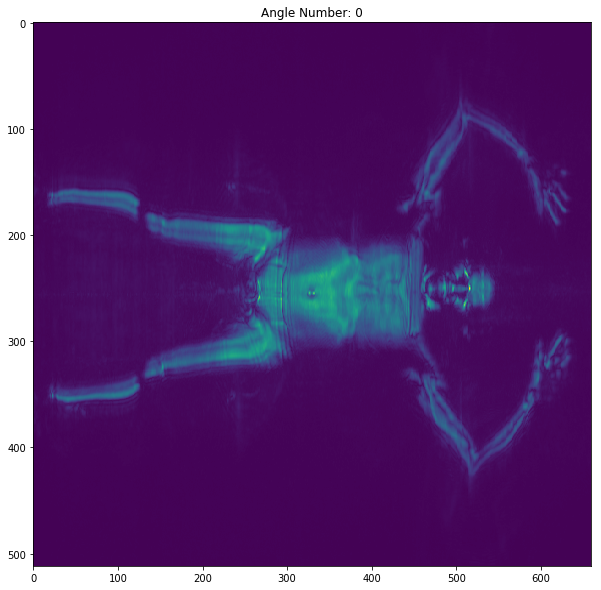

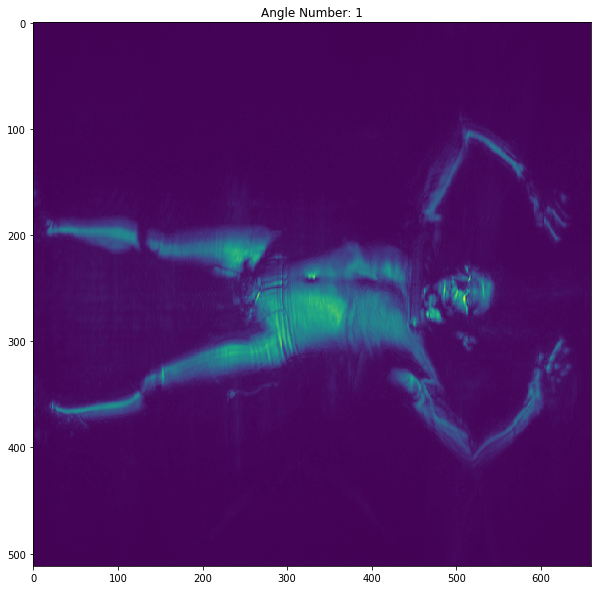

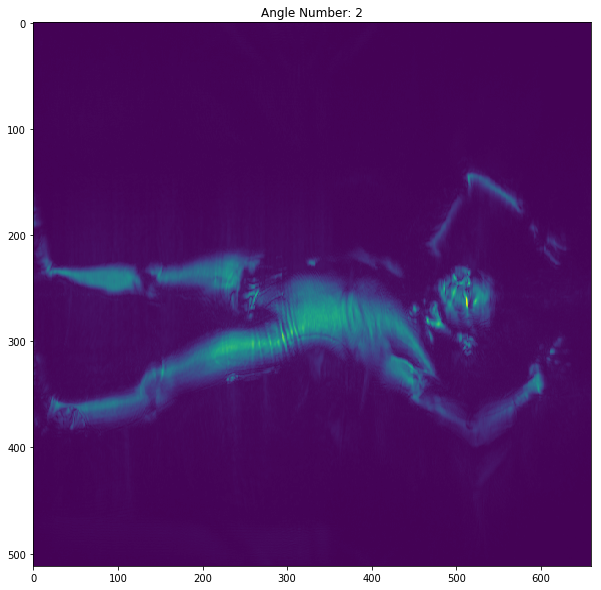

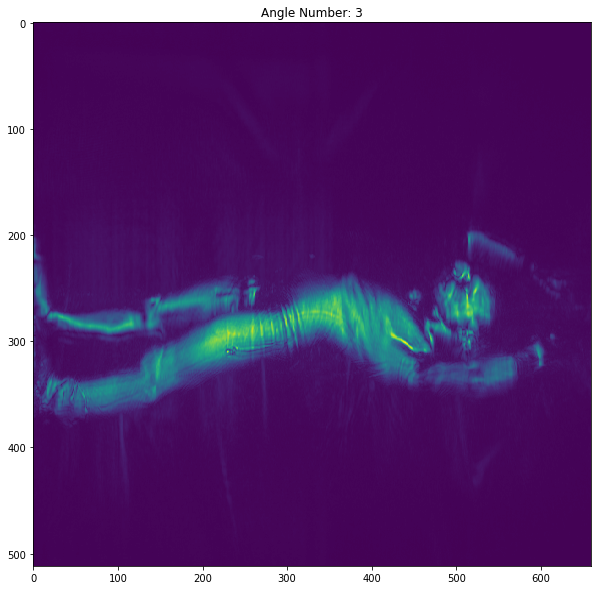

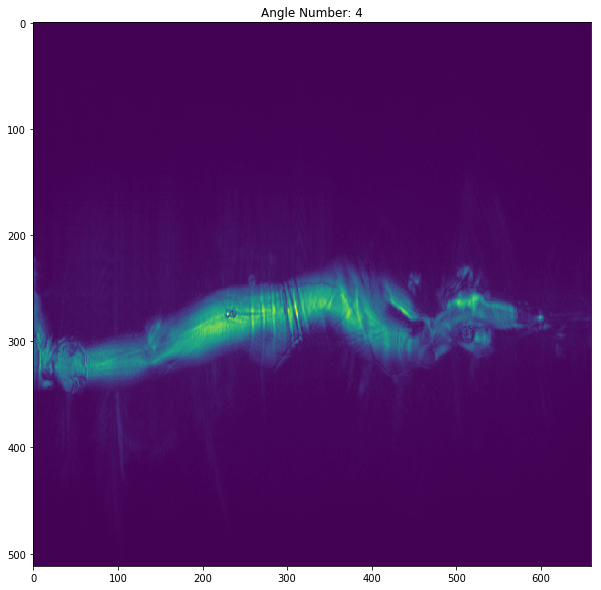

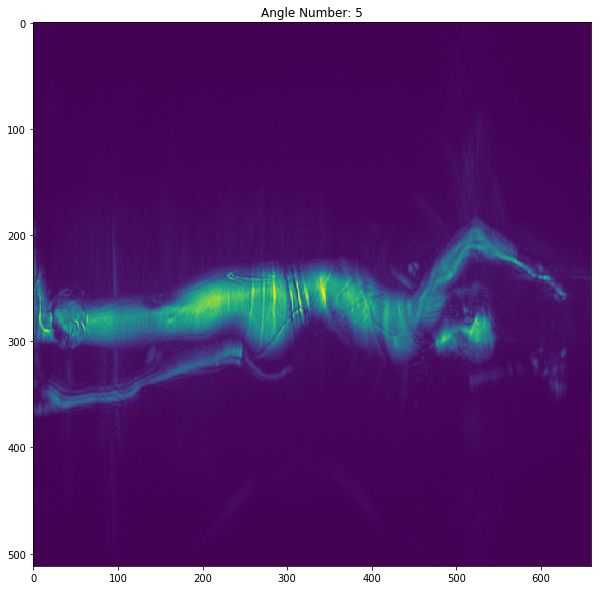

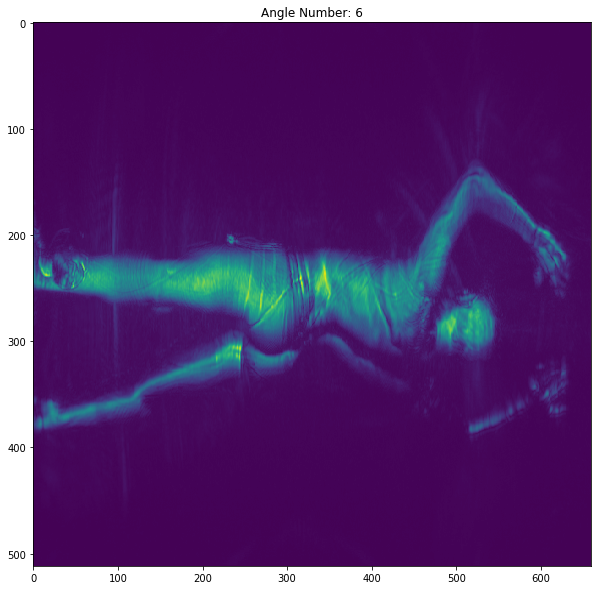

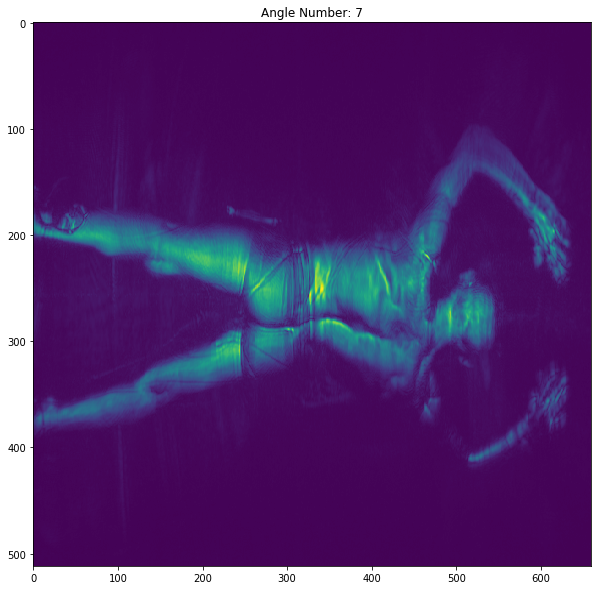

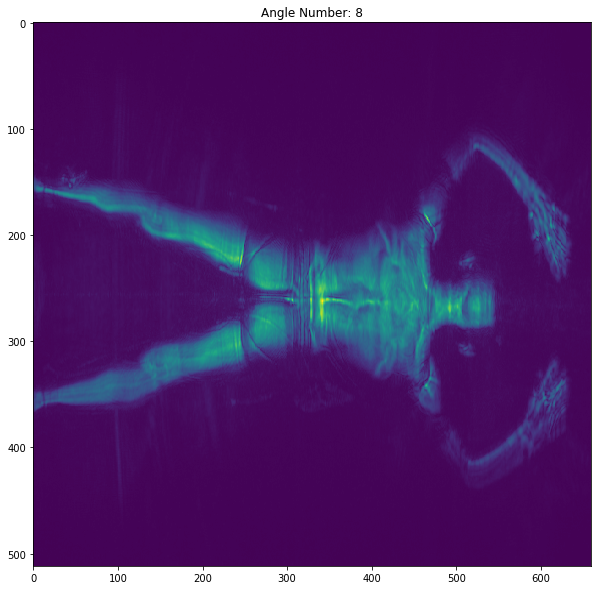

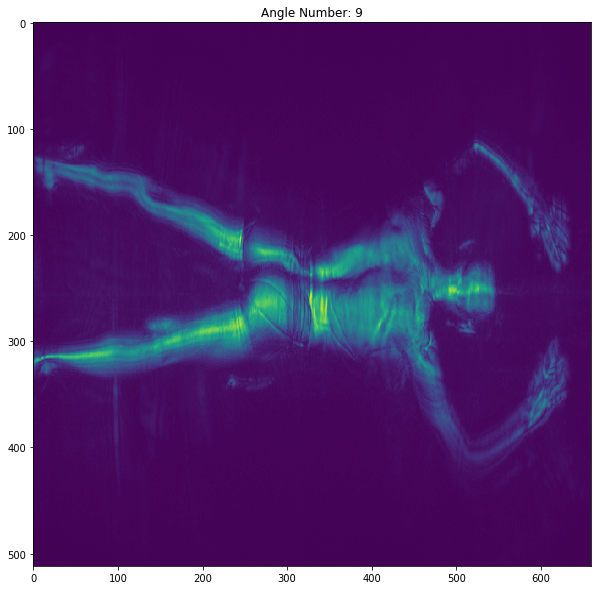

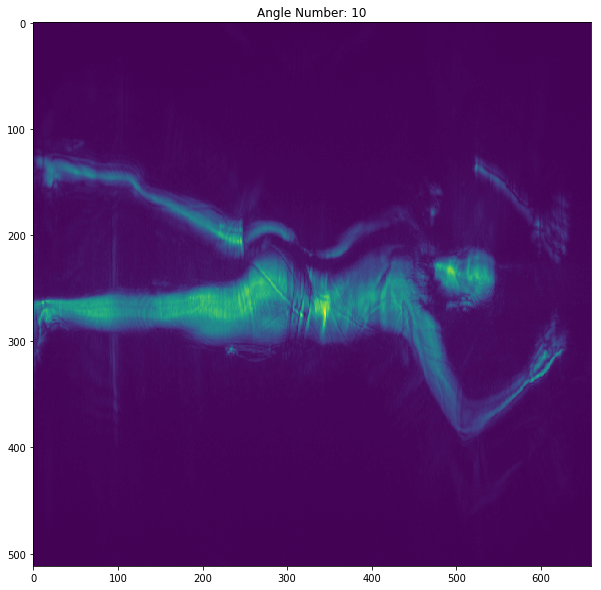

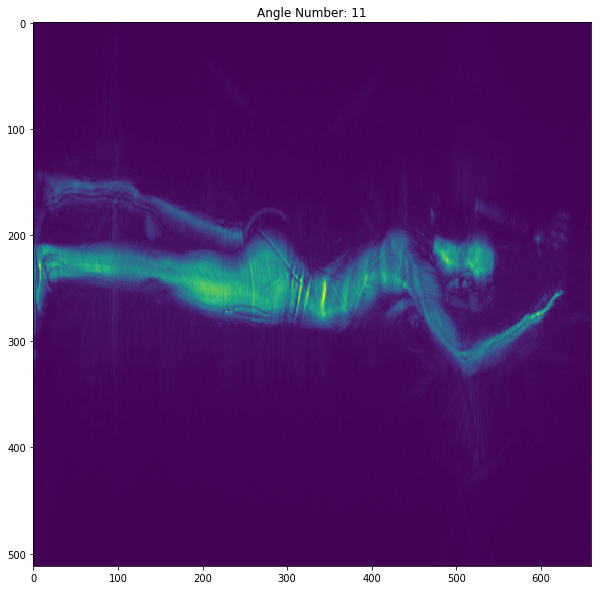

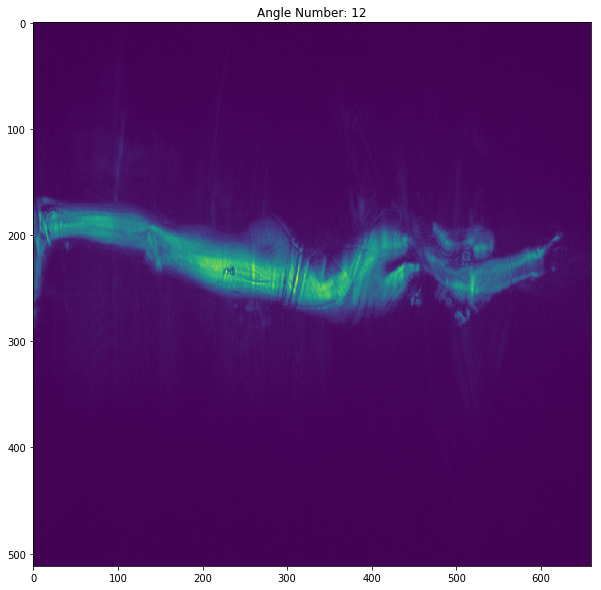

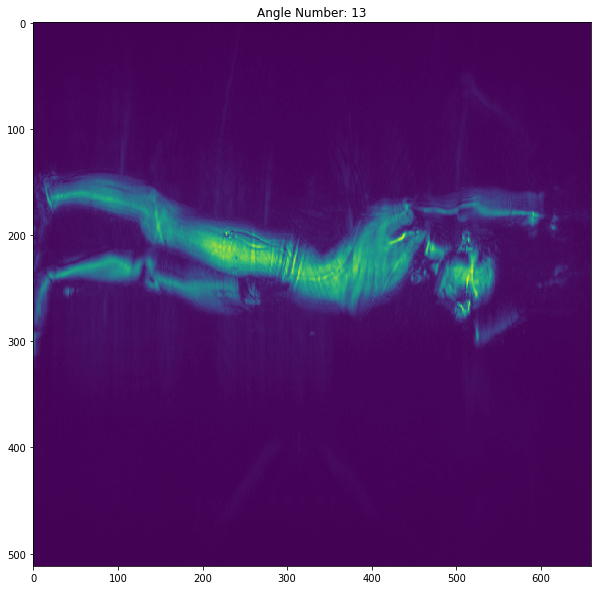

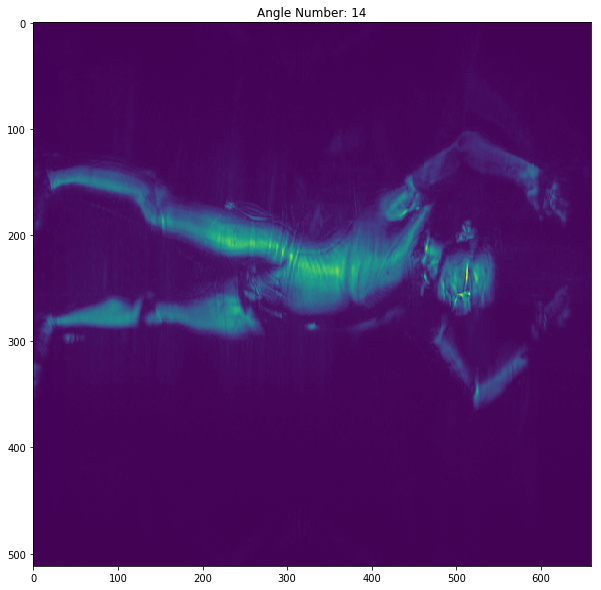

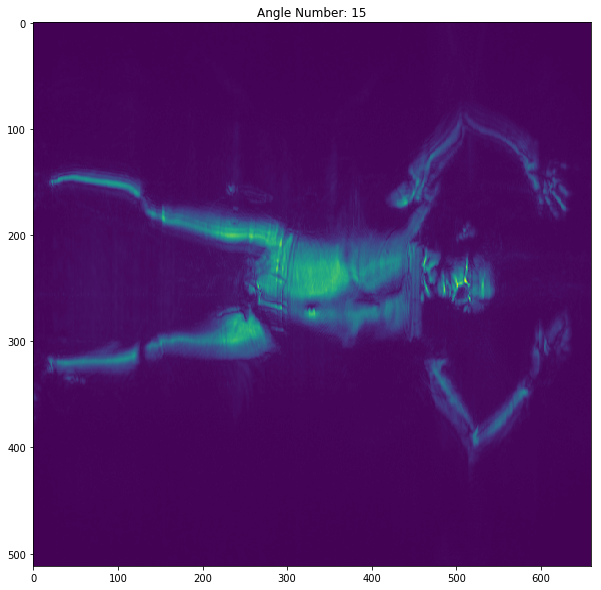

In [15]:
def one_image_full_preprocessing_view(file_name):
    aps_object = read_data(file_name)
    
    # Multiple Angles
    frontal_image = aps_object[:,:,0]
    visualize_one_plane(frontal_image, title = "Frontal Image")
    side_image = aps_object[:, :, 5]
    visualize_one_plane(side_image, title = "Side Image")
    
    # Preprocessing
    cropped_img = crop(frontal_image, crop_list = [150, 350, WIDTH, HEIGHT])
    visualize_one_plane(cropped_img, title = "Cropped Image")
    grayscale_image = convert_to_grayscale(cropped_img)
    visualize_one_plane(grayscale_image, title = "Grayscale Image")
    contrast_image = spread_spectrum(grayscale_image)
    visualize_one_plane(contrast_image, title = "Contrast Enhanced Image")
    normalized_image = normalize(contrast_image)
    visualize_one_plane(normalized_image, title = "Normalized Image")

file_name = '/aps_files/12b19cfb1d7de04755420e90f3dbd08a.aps'
# one_image_full_preprocessing_view(file_name)
aps_object = read_data(file_name)
view_aps_file(aps_object)

In [16]:
(final_subject_list, final_file_name_list) = make_dataset(balanced=False)
(image_list, label_list) = preprocess_pipeline(final_subject_list, final_file_name_list, "Zone5")

Total Subjects: 1147
i: 0
i: 20
i: 40
i: 60
i: 80
i: 100
i: 120
i: 140
i: 160
i: 180
i: 200
i: 220
i: 240
i: 260


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


i: 280
i: 300
i: 320
i: 340
i: 360
i: 380
i: 400
i: 420
i: 440
i: 460
i: 480
i: 500
i: 520
i: 540
i: 560
i: 580
i: 600
i: 620
i: 640
i: 660
i: 680
i: 700
i: 720
i: 740
i: 760
i: 780
i: 800
i: 820
i: 840
i: 860
i: 880
i: 900
i: 920
i: 940
i: 960
i: 980
i: 1000
i: 1020
i: 1040
i: 1060
i: 1080
i: 1100
i: 1120
i: 1140
Done!


# 3. Experimentation and Learning

To train and refine our models on the preprocessed images, we ran over 14 experiments. Initial experiments were aimed at developing a baseline level of prediction across basic architectures (Logistic Regression, a small CNN, and VGG-16). Subsequently, we focused on refining VGG-16 to attain the optimal performance. All experiments are tagged here with their number and can be viewed by scrolling down to the relevant code section of the notebook.  

We selected the Adam optimizer for all experiments due to its effectiveness at dealing with both sparse gradients and noisy gradient changes. As mentioned before, we split the data into 20% testing and then split the remaining data into 80% for training and 20% for validation.


## 3.0 Detecting Threats in the Chest Using Just the Frontal Image
We began by training models with a simplified version of the problem in mind. Could we design an architecture to accurately detect threats specifically within the chest? To tackle this question we began by using a single frontal image only. We used the following architectures.

1. A basic logistic regression unit with a sigmoid output
2. A three layer fully connected neural network with layers of size 12, 8, and 1 feeding to a single sigmoid
3. A basic two layer CNN with:
    - A 2D convolutional layer with 32 (3x3) filters and same pooling
    - A 2D convolutional layer with 32 (3x3) filters and same pooling
    - A Max Pool layer with (2x2) pooling
    - A dropout layer with 50% dropout probability
    - A softmax layer
4. VGG-16
    - Weights were trained on ImageNet and loaded in
    - We removed the last four layers of VGG-16 ("the classification block") which consisted of: a flattening layer, two 4096 node fully connected ReLU layers, and a 10 node fully connected output layer with softmax acivation.
    - We replaced these layers with a single fully connected output layer with two output nodes and a softmax activation. We used two output nodes due to the shape of our labels ([0, 1] for no threat and [1, 0] for a threat) and a softmax for the same reason.

At this point, we did not save the results. However, they were lower than using three frontal images (section 3.1). 



## 3.1 Detecting Threats in the Chest Using Three Frontal Images
Next, we attempted to improve three of the models (the logistic regression, the two layer CNN, and VGG-16) by using the three most frontal angles. Since threats on the chest can be mostly seen images taken from slight angles, we suspected this would increase the size of our data in a meaningful way. The architectures were otherwise unchanged.  
1. [Experiment 7.1] A basic logistic regression unit with a softmax output described in Section 3.0
2. [Experiment 7.2] A three layer fully connected neural network described in Section 3.0
3. [Experiment 7.3] A basic two layer CNN described in Section 3.0
4. [Experiment 7.4] VGG-16 as described in Section 3.0

The results on the test data were as follows:


<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-yw4l{vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-yw4l"></th>
    <th class="tg-yw4l">Logistic Regression</th>
    <th class="tg-yw4l">Three Layer FC NN</th>
    <th class="tg-yw4l">Basic CNN</th>
    <th class="tg-yw4l">VGG-16</th>
  </tr>
  <tr>
    <td class="tg-yw4l">Loss</td>
    <td class="tg-yw4l">0.563</td>
    <td class="tg-yw4l">0.848</td>
    <td class="tg-yw4l">0.760</td>
    <td class="tg-yw4l">0.144</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Accuracy</td>
    <td class="tg-yw4l">0.906</td>
    <td class="tg-yw4l">0.911</td>
    <td class="tg-yw4l">0.927</td>
    <td class="tg-yw4l">0.952</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Precision</td>
    <td class="tg-yw4l">0.440</td>
    <td class="tg-yw4l">0.586</td>
    <td class="tg-yw4l">0.933</td>
    <td class="tg-yw4l">0.932</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Recall</td>
    <td class="tg-yw4l">0.177</td>
    <td class="tg-yw4l">0.258</td>
    <td class="tg-yw4l">0.222</td>
    <td class="tg-yw4l">0.577</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Specificity</td>
    <td class="tg-yw4l">0.978</td>
    <td class="tg-yw4l">0.981</td>
    <td class="tg-yw4l">0.998</td>
    <td class="tg-yw4l">0.995</td>
  </tr>
  <tr>
    <td class="tg-yw4l">False Positive Rate</td>
    <td class="tg-yw4l">0.022</td>
    <td class="tg-yw4l">0.019</td>
    <td class="tg-yw4l">0.002</td>
    <td class="tg-yw4l">0.005</td>
  </tr>
</table>
![three_frontal](images/Three_Frontal_Zones_Results.png)

We had multiple learnings:
1. Using three angles instead of just one improved the validation losses and testing losses. We suspect this was the case because a threat on the chest can be partially viewed from slightly different angles. As a result the additional training examples were useful. All subsequent experiments were run with the three frontal images. 
1. All models were overfitting. We initially ran for 100 epochs but we decided we should stop early (13 epochs for VGG-16) based on where the validation loss began to increase.
2. VGG-16 outperformed all of the other models across loss, accuracy, precision, and recall. As a result, we decided to focus on fine-tuning VGG-16 moving forward.


## 3.2 Tuning VGG-16 to not overfit

We now focused on fine tuning VGG-16. The first challenge involved stopping VGG-16 from overfitting. In addition to stopping early (after just 13 epochs), we modified our architecture. Instead of replacing the last layer of VGG-16 with a single fully connected layer, we now replaced the last layer of VGG-16 with two fully connected layers and a dropout layer in between. We then fine-tuned the dropout parameter. Since neither of the dropout values we tested were sufficient, we tested an iteration which implemented L2 regularization on these two layers. Overall, the experiments were as follows:
1. [Experiment 7.5] VGG16 with two layers added at the end and a dropout layer in between with dropout parameter = 0.5
2. [Experiment 7.6] VGG16 with two layers added at the end and a dropout layer in between with dropout parameter = 0.75
3. Numerous experiments testing VGG16 with two layers at the end, a dropout parameter of 0.75 and L2 regularization with various parameters
    - [Experiment 7.8] L2 param = 0.001
    - [Experiment 7.7] L2 param = 0.01
    - [Experiment 7.9] L2 param = 0.1
    
The test results were as follows:
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-yw4l{vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-yw4l"></th>
    <th class="tg-yw4l">Dropout = 0.5</th>
    <th class="tg-yw4l">Dropout = 0.75</th>
    <th class="tg-yw4l">Dropout = 0.75, L2 = 0.001</th>
    <th class="tg-yw4l">Dropout = 0.75, L2 = 0.01</th>
    <th class="tg-yw4l">Dropout = 0.75, L2 = 0.1</th>
  </tr>
  <tr>
    <td class="tg-yw4l">Loss</td>
    <td class="tg-yw4l">0.146</td>
    <td class="tg-yw4l">0.138</td>
    <td class="tg-yw4l">0.139</td>
    <td class="tg-yw4l">0.155</td>
    <td class="tg-yw4l">0.148</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Accuracy</td>
    <td class="tg-yw4l">0.949</td>
    <td class="tg-yw4l">0.952</td>
    <td class="tg-yw4l">0.954</td>
    <td class="tg-yw4l">0.950</td>
    <td class="tg-yw4l">0.950</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Precision</td>
    <td class="tg-yw4l">0.909</td>
    <td class="tg-yw4l">0.913</td>
    <td class="tg-yw4l">0.933</td>
    <td class="tg-yw4l">0.951</td>
    <td class="tg-yw4l">0.930</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Recall</td>
    <td class="tg-yw4l">0.563</td>
    <td class="tg-yw4l">0.592</td>
    <td class="tg-yw4l">0.592</td>
    <td class="tg-yw4l">0.549</td>
    <td class="tg-yw4l">0.563</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Specificity</td>
    <td class="tg-yw4l">0.994</td>
    <td class="tg-yw4l">0.994</td>
    <td class="tg-yw4l">0.995</td>
    <td class="tg-yw4l">0.996</td>
    <td class="tg-yw4l">0.995</td>
  </tr>
  <tr>
    <td class="tg-yw4l">False Positive Rate</td>
    <td class="tg-yw4l">0.006</td>
    <td class="tg-yw4l">0.006</td>
    <td class="tg-yw4l">0.005</td>
    <td class="tg-yw4l">0.003</td>
    <td class="tg-yw4l">0.005</td>
  </tr>
</table>

![overfitting](images/overfitting_comparison.png)

<!--1. VGG16 with two layers added at the end, dropout = 0.5
    Loss: 0.146093218407
    Accuracy: 0.949201741655
    Precision: 0.909090909091
    Recall: 0.56338028169
    Specificity: 0.993527508091
    False positive rate: 0.00647249190939
2. VGG16 with two layers added at the end, dropout = 0.75
    Loss: 0.138008573817
    Accuracy: 0.952104499274
    Precision: 0.913043478261
    Recall: 0.591549295775
    Specificity: 0.993527508091
    False positive rate: 0.00647249190939
3. VGG16 with two layers added at the end, dropout = 0.75 and L2 regularization for the two fully connected layers
    a. L2 param = 0.01 
        Loss: 0.155018835823
        Accuracy: 0.950653120464
        Precision: 0.951219512195
        Recall: 0.549295774648
        Specificity: 0.996763754045
        False positive rate: 0.00323624595469
    b. L2 param = 0.001
        Loss: 0.139987724259
        Accuracy: 0.953555878084
        Precision: 0.933333333333
        Recall: 0.591549295775
        Specificity: 0.995145631068
        False positive rate: 0.00485436893204
   c. L2 param = 0.1
        Loss: 0.148567957187
        Accuracy: 0.950653120464
        Precision: 0.93023255814
        Recall: 0.56338028169
        Specificity: 0.995145631068
        False positive rate: 0.00485436893204-->
        
From these we learned:
1. Overall, VGG-16 worked best with dropout = 0.75 and L2 regularization of 0.001. The loss was substantially improved and although a slight amount of overfitting still occurred it was substantially reduced compared to prior cases.
2. Separately, we realized at this point that our recall numbers were generally poor. Our  models were only detecting ~50% of threats. In other words, the model accuracy was primarily deriving from being very good at predicting when a threat didn't occur but was poor at predicting images with threats. This largely resulted from the class imbalance problem. 

## 3.3. Improving recall with a class weighted loss

After Section 3.2, we realized that the most relevant evaluation metric is recall. Indeed, missing a threat is far worse than generating an additional security screen. For our subsequent iterations therefore, we tried to minimize recall while also keeping the loss below 0.20. All subsequent experiments followed that evaluation metric.   

To improve recall, we utilized class weighted cross entropy loss which functions by applying a weight to each term (discussed in introduction). By more heavily penalizing false negatives, we sought to improve our recall. Additionally, we hoped this would deal with the class imbalance problem.   

[Experiment 7.10] We iterated on the optimal architecture from Experiment 7.9, this time adding class weighted loss:
- VGG with two fully connected layers at the end
- A dropout layer in between with dropout parameter 0.75
- L2 regularization with L2 parameters = 0.001
- Class weighted loss. 

The test results were as follows and are directly compared to the best architecture from Section 3.2 (Experiment 7.9). 
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-yw4l{vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-yw4l"></th>
    <th class="tg-yw4l">Dropout = 0.75, L2 = 0.001</th>
    <th class="tg-yw4l">Dropout = 0.75, L2 = 0.001, Class Weighted Loss</th>
  </tr>
  <tr>
    <td class="tg-yw4l">Loss</td>
    <td class="tg-yw4l">0.139</td>
    <td class="tg-yw4l">0.143</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Accuracy</td>
    <td class="tg-yw4l">0.954</td>
    <td class="tg-yw4l">0.950</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Precision</td>
    <td class="tg-yw4l">0.933</td>
    <td class="tg-yw4l">0.824</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Recall</td>
    <td class="tg-yw4l">0.592</td>
    <td class="tg-yw4l">0.661</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Specificity</td>
    <td class="tg-yw4l">0.995</td>
    <td class="tg-yw4l">0.983</td>
  </tr>
  <tr>
    <td class="tg-yw4l">False Positive Rate</td>
    <td class="tg-yw4l">0.005</td>
    <td class="tg-yw4l">0.016</td>
  </tr>
</table>


<!--Loss: 0.143885913977
Accuracy: 0.950653120464  
Precision: 0.824561403509  
Recall: 0.661971830986  
Specificity: 0.983818770227  
False positive rate: 0.0161812297735  
--> 
The recall substantially improved and so we kept the class weighted loss moving forward.

## 3.4 Improving recall by training more layers of VGG-16
Finally, we sought to further improve recall by training more layers of VGG-16. In prior models we were only training the last few layers (i.e. those we had added on). The prior layers were fixed based on weights learned on ImageNet. Now, we tested whether training both of the last layers of VGG-16 in addition to custom layers we added improve loss and recall?  

[Experiment 7.11] Iterating on the architecture from [Experiment 7.10], we now also retrained both of the last layers of VGG-16 instead of just the last layer.

Test results were as follows:
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-yw4l{vertical-align:top}
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-yw4l{vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-yw4l"></th>
    <th class="tg-yw4l">Retraining just last layer (prior best)</th>
    <th class="tg-yw4l">Retraining two additional layers</th>
  </tr>
  <tr>
    <td class="tg-yw4l">Loss</td>
    <td class="tg-yw4l">0.143</td>
    <td class="tg-yw4l">0.179</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Accuracy</td>
    <td class="tg-yw4l">0.950</td>
    <td class="tg-yw4l">0.967</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Precision</td>
    <td class="tg-yw4l">0.824</td>
    <td class="tg-yw4l">0.944</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Recall</td>
    <td class="tg-yw4l">0.661</td>
    <td class="tg-yw4l">0.718</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Specificity</td>
    <td class="tg-yw4l">0.983</td>
    <td class="tg-yw4l">0.995</td>
  </tr>
  <tr>
    <td class="tg-yw4l">False Positive Rate</td>
    <td class="tg-yw4l">0.016</td>
    <td class="tg-yw4l">0.005</td>
  </tr>
</table>

We learned that:
1. Training the last two layers of VGG-16 substantially improved recall while keeping loss below 0.200.


<!--Final tuning occurred by:
1. Training both of the last layers of VGG-16 instead of just the last layer.
The results were:  
Loss: 0.179748126651  
Accuracy: 0.966618287373  
Precision: 0.944444444444  
Recall: 0.718309859155  
Specificity: 0.995145631068  
False positive rate: 0.00485436893204  

2. Initializing VGG16 with random weights and learning. 
Loss: 0.14391521658  
Accuracy: 0.952104499274  
Precision: 0.895833333333  
Recall: 0.605633802817  
Specificity: 0.991909385113  
False positive rate: 0.00809061488673 -->


## 3.5 Summary of our best performing model
Experiment 7.11 was our best performing model. Finally, we combined all of our learnings from the previous experiments to produce our best performing model in terms of maximizing recall while keeping a loss beneath 0.200.
1. VGG-16 removing the "categorization" layers described above
2. Adding two fully connected layers with a dropout layer in between of 0.75
3. Adding L2 regularization of 0.001 for those two layers
4. With a cross weighted loss
5. Training on both our last two layers AND the last two layers of VGG-16

The test results were as follows:  
- Loss: 0.179748126651
- Accuracy: 0.966618287373
- Precision: 0.944444444444
- Recall: 0.718309859155
- Specificity: 0.995145631068
- False positive rate: 0.00485436893204 


![last](images/final_architecture.png)  

We ultimately realized that this model was slightly overfitting and we would employ early stopping at epoch 6 in the future to further decrease our loss.


<!--![overall1](images/overall_comparison2.png)--->

# 4. Evaluation of Our Best Peforming Model on Images of the Back.

Curious to see if our model generalized to other threat zones, we trained our best performing model on images of the chest and then tested it on images of the back. We had the following test results:
- Loss: 1.52935689802  
- Accuracy: 0.848299912868  
- Precision: 0.0812720848057  
- Recall: 0.080701754386  
- Specificity: 0.917617237009  
- False positive rate: 0.0823827629911  

Note the increase in loss. Therefore, our architecture is overfitting to the chest. Even though the chest and back have similar sizes, their topographies and image characteristics differ. More work would be required to generalize this algorithm to other zones.


# 5. Future Work

Future work involves:
1. Further refinement of the VGG architecture by
- Increasing the size of our positive data by using more angles (we are currently using only 3)
- Augmenting our data by adding noise to the positive examples which will hopefully also improve class balance
- Collecting and using external data to train on
2. Attempting other architectures such as ResNet or GoogleNet. 
3. Expanding our work to predict on all threat zones. Here we would consider soft multitask models (where each zone has its own model, but we use regularization for the parameters) or hard multitask models (where all the models share a number of layers, after which they diverge on their own).

# 6. Contributions

Camilo and Ana-Maria both contributed to all parts of the project. We jointly wrote all code and written material.

# 7. Code for all experiments

In [17]:
def get_input(image_list, label_list):
    # First, handle images
    flattened_image_list = []

    for image in image_list:
        image = image[:, :, 0]
        image = image.flatten()
        flattened_image_list.append(image)

    flattened_input = np.array(flattened_image_list)
    
    # Next, handle labels
    label_array = np.array(label_list)
    label_array = label_array[:,0]
    
    return (flattened_input, label_array)

In [62]:
import json
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import TensorBoard
from keras.models import load_model
from keras import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix

TENSORBOARD_LOGDIR_LOGISTIC = './keras_logistic-regression'
TENSORBOARD_LOGDIR_BASIC_NN = './keras_basic-nn'
TENSORBOARD_LOGDIR_BASIC_CNN = './keras_basic-cnn'
TENSORBOARD_LOGDIR_VGG16 = './keras_vgg_16'
# TENSORBOARD_LOGDIR_LOGISTIC = './vgg-16-slides-4'
FULL_MODEL_LOGISTIC_REGRESSION = 'model/keras_logistic_regression.h5'
FULL_MODEL_BASIC_NN = 'model/keras_basic_nn.h5'
FULL_MODEL_BASIC_CNN = 'model/keras_basic_cnn.h5'
FULL_MODEL_VGG16 = 'model/keras_vgg16'

JSON_LOGISTIC_REGRESSION = 'json/keras_logistic_regression.json'
JSON_BASIC_NN = 'json/keras_basic_nn.json'
JSON_BASIC_CNN = 'json/keras_basic_cnn.json'
JSON_VGG16 = 'json/keras_vgg16'

WEIGHTS_LOGISTIC_REGRESSION = 'weights/keras_logistic_regression.h5'
WEIGHTS_BASIC_NN = 'weights/keras_basic_nn.h5'
WEIGHTS_BASIC_CNN = 'weights/keras_basic_cnn.h5'
WEIGHTS_VGG16 = 'weights/keras_vgg16'

In [19]:
def get_predictions(y_pred, output_is_2d):
    if output_is_2d:
        y = []
        for i in y_pred:
            if i[1] > 0.5:
                y.append(0)
            else:
                y.append(1)
        y_pred = y
    else:
        y_pred[y_pred >= 0.5] = 1
        y_pred[y_pred < 0.5] = 0
    return y_pred 

In [20]:
def get_metrics(model, x_test, y_test, output_is_2d = True):
    test_metrics = model.evaluate(x_test, y_test)
    print("Loss: " + str(test_metrics[0]))
    print("Accuracy: " + str(test_metrics[1]))

    y_pred = model.predict(x_test)
    y_pred = get_predictions(y_pred, output_is_2d)
    y_true = get_predictions(y_test, output_is_2d)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    precision = tp / (tp + fp) #positive predictive value
    recall = tp / (tp + fn) #true positive rate
    specificity = tn / (tn + fp) # true negative rate
    false_positive_rate = fp / (fp + tn) #false positive rate
    print("Precision: " + str(precision))
    print("Recall: " + str(recall))
    print("Specificity: " + str(specificity))
    print("False positive rate: " + str(false_positive_rate))

## 7.1 Basic Logistic Regression

In [22]:
def keras_logistic_regression(x, y, num_epochs, weights_path = None):
    # 2-class logistic regression in Keras
    model = Sequential()
    model.add(Dense(1, activation='sigmoid', input_dim=x.shape[1]))
    if weights_path:
        model.load_weights(weights_path)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
    
    tbCallBack = TensorBoard(log_dir=TENSORBOARD_LOGDIR_LOGISTIC, histogram_freq=0, write_graph=True, write_images=True)
    model.fit(x, y, epochs = num_epochs, validation_split = 0.2, callbacks=[tbCallBack])
    
    return model

In [23]:
x, y = get_input(image_list, label_list)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [24]:
# save the model, so it can be loaded after
logistic_regression_model = keras_logistic_regression(x_train, y_train, num_epochs = 100)
logistic_regression_model.save(FULL_MODEL_LOGISTIC_REGRESSION)
logistic_regression_model.save_weights(WEIGHTS_LOGISTIC_REGRESSION)
with open(JSON_LOGISTIC_REGRESSION, 'w') as outfile:
    json.dump(logistic_regression_model.to_json(), outfile)

Train on 2201 samples, validate on 551 samples
Epoch 1/100
2201/2201 [==============================] - 0s - loss: 0.4477 - acc: 0.8832 - val_loss: 0.2928 - val_acc: 0.9165
Epoch 2/100
2201/2201 [==============================] - 0s - loss: 0.2992 - acc: 0.9064 - val_loss: 0.3667 - val_acc: 0.8784
Epoch 3/100
2201/2201 [==============================] - 0s - loss: 0.2938 - acc: 0.9010 - val_loss: 0.3157 - val_acc: 0.9056
Epoch 4/100
2201/2201 [==============================] - 0s - loss: 0.2496 - acc: 0.9109 - val_loss: 0.2984 - val_acc: 0.9183
Epoch 5/100
2201/2201 [==============================] - 0s - loss: 0.1971 - acc: 0.9300 - val_loss: 0.2809 - val_acc: 0.9183
Epoch 6/100
2201/2201 [==============================] - 0s - loss: 0.2012 - acc: 0.9282 - val_loss: 0.3347 - val_acc: 0.9165
Epoch 7/100
2201/2201 [==============================] - 0s - loss: 0.1766 - acc: 0.9364 - val_loss: 0.3447 - val_acc: 0.8621
Epoch 8/100
2201/2201 [==============================] - 0s - loss: 0.1

In [25]:
# model = load_model(FULL_MODEL_LOGISTIC_REGRESSION)
get_metrics(logistic_regression_model, x_test, y_test, output_is_2d = False)

448/689 [==================>...........] - ETA: 0sLoss: 0.563293484022
Accuracy: 0.905660377532
Precision: 0.44
Recall: 0.177419354839
Specificity: 0.977671451356
False positive rate: 0.0223285486443


## 7.2 Basic Three Layer Neural Network

In [33]:
def keras_basic_nn(x, y, num_epochs):
    model = Sequential()
    model.add(Dense(12, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
    
    tbCallBack = TensorBoard(log_dir=TENSORBOARD_LOGDIR_BASIC_NN, histogram_freq=0, write_graph=True, write_images=True)
    model.fit(x, y, nb_epoch=num_epochs, validation_split = 0.2, callbacks=[tbCallBack])

    return model

In [29]:
x, y = get_input(image_list, label_list)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
basic_nn_model_100_epochs = keras_basic_nn(x_train, y_train, 100)

/usr/local/lib/python3.6/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 2201 samples, validate on 551 samples
Epoch 1/100
2201/2201 [==============================] - 0s - loss: 0.3078 - acc: 0.9055 - val_loss: 0.3495 - val_acc: 0.8947
Epoch 2/100
2201/2201 [==============================] - 0s - loss: 0.2817 - acc: 0.9119 - val_loss: 0.3541 - val_acc: 0.8984
Epoch 3/100
2201/2201 [==============================] - 0s - loss: 0.2754 - acc: 0.9146 - val_loss: 0.3863 - val_acc: 0.8730
Epoch 4/100
2201/2201 [==============================] - 0s - loss: 0.2555 - acc: 0.9132 - val_loss: 0.4402 - val_acc: 0.8947
Epoch 5/100
2201/2201 [==============================] - 0s - loss: 0.2440 - acc: 0.9178 - val_loss: 0.3629 - val_acc: 0.8966
Epoch 6/100
2201/2201 [==============================] - 0s - loss: 0.2348 - acc: 0.9223 - val_loss: 0.4774 - val_acc: 0.8947
Epoch 7/100
2201/2201 [==============================] - 0s - loss: 0.2206 - acc: 0.9228 - val_loss: 0.3435 - val_acc: 0.8966
Epoch 8/100
2201/2201 [==============================] - 0s - loss: 0.2

In [30]:
basic_nn_model.save(FULL_MODEL_BASIC_NN)
basic_nn_model.save_weights(WEIGHTS_BASIC_NN)
with open(JSON_BASIC_NN, 'w') as outfile:
    json.dump(basic_nn_model.to_json(), outfile)

In [32]:
get_metrics(basic_nn_model, x_test, y_test, output_is_2d = False)

480/689 [===================>..........] - ETA: 0sLoss: 0.847540670884
Accuracy: 0.911465894155
Precision: 0.586206896552
Recall: 0.257575757576
Specificity: 0.980738362761
False positive rate: 0.0192616372392


## 7.3 Basic CNN

In [34]:
def prepare_x_y_for_conv(image_list, label_list):
    image_array = np.array(image_list)
    print(image_array.shape)

    i = 0
    for element in label_list:
        if element[0] == 0:
            label_list[i] = [0, 1]
        elif element[0] == 1:
            label_list[i] = [1, 0]
        i += 1

    label_array = np.array(label_list)

    x = image_array
    y = label_array

    return (x, y)

In [35]:
from keras.models import Model # basic class for specifying and training a neural network
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from keras.utils import np_utils # utilities for one-hot encoding of ground truth values
import numpy as np

def basic_conv_2d(x, y, num_epochs):
    batch_size = 32 # in each iteration, we consider 32 training examples at once
    kernel_size = 3 # we will use 3x3 kernels throughout
    pool_size = 2 # we will use 2x2 pooling throughout
    conv_depth_1 = 32 # we will initially have 32 kernels per conv. layer...
    drop_prob_1 = 0.75 # dropout after pooling with probability 0.25

    num_total, height, width, depth = x.shape # there are 50000 training examples in CIFAR-10 
    num_classes = 2

    inp = Input(shape=(height, width, depth)) # depth goes last in TensorFlow back-end (first in Theano)
    # Conv [32] -> Conv [32] -> Pool (with dropout on the pooling layer)
    conv_1 = Convolution2D(conv_depth_1, (kernel_size, kernel_size), padding='same', activation='relu')(inp)
    conv_2 = Convolution2D(conv_depth_1, (kernel_size, kernel_size), padding='same', activation='relu')(conv_1)
    pool_1 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_2)
    drop_1 = Dropout(drop_prob_1)(pool_1)
    flattened= Flatten()(drop_1)
    out = Dense(num_classes, activation='softmax')(flattened)

    model = Model(inputs=inp, outputs=out) # To define a model, just specify its input and output layers

    model.summary()

    model.compile(loss='binary_crossentropy', # using the cross-entropy loss function
                  optimizer='adam', # using the Adam optimiser
                  metrics=['accuracy']) # reporting the accuracy

    tbCallBack = TensorBoard(log_dir=TENSORBOARD_LOGDIR_BASIC_CNN, histogram_freq=0, write_graph=True, write_images=True)
    model.fit(x, y, nb_epoch=num_epochs, verbose=1, validation_split=0.2, callbacks=[tbCallBack]) # ...holding out 10% of the data for validation

    return model 

In [36]:
(x, y) = prepare_x_y_for_conv(image_list, label_list)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
conv_2d_model = basic_conv_2d(x_train, y_train, num_epochs = 100)

(3441, 175, 175, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 175, 175, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 175, 175, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 175, 175, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 87, 87, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 87, 87, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 242208)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 4

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2201 samples, validate on 551 samples
Epoch 1/100
2201/2201 [==============================] - 9s - loss: 0.3579 - acc: 0.9046 - val_loss: 0.3352 - val_acc: 0.9002
Epoch 2/100
2201/2201 [==============================] - 8s - loss: 0.2972 - acc: 0.9091 - val_loss: 0.3402 - val_acc: 0.9002
Epoch 3/100
2201/2201 [==============================] - 8s - loss: 0.2991 - acc: 0.9096 - val_loss: 0.3288 - val_acc: 0.9002
Epoch 4/100
2201/2201 [==============================] - 8s - loss: 0.2619 - acc: 0.9105 - val_loss: 0.3471 - val_acc: 0.8838
Epoch 5/100
2201/2201 [==============================] - 8s - loss: 0.2565 - acc: 0.9123 - val_loss: 0.2934 - val_acc: 0.8984
Epoch 6/100
2201/2201 [==============================] - 8s - loss: 0.1984 - acc: 0.9246 - val_loss: 0.2878 - val_acc: 0.9074
Epoch 7/100
2201/2201 [==============================] - 8s - loss: 0.1491 - acc: 0.9459 - val_loss: 0.2771 - val_acc: 0.9165
Epoch 8/100
2201/2201 [==============================] - 8s - loss: 0.0

In [44]:
print(x.shape)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(3441, 175, 175, 1)
(2752, 175, 175, 1)
(689, 175, 175, 1)
(2752, 2)
(689, 2)


In [45]:
conv_2d_model.save(FULL_MODEL_BASIC_CNN)
conv_2d_model.save_weights(WEIGHTS_BASIC_CNN)
with open(JSON_BASIC_CNN, 'w') as outfile:
    json.dump(conv_2d_model.to_json(), outfile)

In [48]:
get_metrics(conv_2d_model, x_test, y_test, output_is_2d = True)

689/689 [==============================] - 0s     
Loss: 0.760292361976
Accuracy: 0.927431059853
Precision: 0.933333333333
Recall: 0.222222222222
Specificity: 0.998402555911
False positive rate: 0.00159744408946


## 7.4 VGG-16 one layer added at the end, no dropout

This code was adapted from https://github.com/keras-team/keras/blob/master/keras/applications/vgg16.py and then modified to fit our dataset and experiments.

In [49]:
def prepare_three_channel_input(x, y):
    x = np.repeat(x, 3, axis = 3)   
    return (x, y)

In [50]:
# -*- coding: utf-8 -*-
"""VGG16 model for Keras.
# Reference
- [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)
"""
from __future__ import print_function
from __future__ import absolute_import

import os
import warnings

from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K


WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

def decode_predictions(preds, top=5):
    """Decodes the prediction of an ImageNet model.
    # Arguments
        preds: Numpy tensor encoding a batch of predictions.
        top: integer, how many top-guesses to return.
    # Returns
        A list of lists of top class prediction tuples
        `(class_name, class_description, score)`.
        One list of tuples per sample in batch input.
    # Raises
        ValueError: in case of invalid shape of the `pred` array
            (must be 2D).
    """
    global CLASS_INDEX
    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects '
                         'a batch of predictions '
                         '(i.e. a 2D array of shape (samples, 1000)). '
                         'Found array with shape: ' + str(preds.shape))
    if CLASS_INDEX is None:
        fpath = get_file('imagenet_class_index.json',
                         CLASS_INDEX_PATH,
                         cache_subdir='models',
                         file_hash='c2c37ea517e94d9795004a39431a14cb')
        CLASS_INDEX = json.load(open(fpath))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results

def preprocess_input(x, data_format=None, mode='caffe'):
    """Preprocesses a tensor encoding a batch of images.
    # Arguments
        x: input Numpy or symoblic tensor, 3D or 4D.
        data_format: data format of the image tensor.
        mode: One of "caffe", "tf".
            - caffe: will convert the images from RGB to BGR,
                then will zero-center each color channel with
                respect to the ImageNet dataset,
                without scaling.
            - tf: will scale pixels between -1 and 1,
                sample-wise.
    # Returns
        Preprocessed tensor.
    """
    if data_format is None:
        data_format = K.image_data_format()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Unknown data_format ' + str(data_format))

    if isinstance(x, np.ndarray):
        return _preprocess_numpy_input(x, data_format=data_format, mode=mode)
    else:
        return _preprocess_symbolic_input(x, data_format=data_format,
                                          mode=mode)
    
def _obtain_input_shape(input_shape,
                        default_size,
                        min_size,
                        data_format,
                        require_flatten,
                        weights=None):
    """Internal utility to compute/validate an ImageNet model's input shape.
    # Arguments
        input_shape: either None (will return the default network input shape),
            or a user-provided shape to be validated.
        default_size: default input width/height for the model.
        min_size: minimum input width/height accepted by the model.
        data_format: image data format to use.
        require_flatten: whether the model is expected to
            be linked to a classifier via a Flatten layer.
        weights: one of `None` (random initialization)
            or 'imagenet' (pre-training on ImageNet).
            If weights='imagenet' input channels must be equal to 3.
    # Returns
        An integer shape tuple (may include None entries).
    # Raises
        ValueError: in case of invalid argument values.
    """
    if weights != 'imagenet' and input_shape and len(input_shape) == 3:
        if data_format == 'channels_first':
            if input_shape[0] not in {1, 3}:
                warnings.warn(
                    'This model usually expects 1 or 3 input channels. '
                    'However, it was passed an input_shape with ' +
                    str(input_shape[0]) + ' input channels.')
            default_shape = (input_shape[0], default_size, default_size)
        else:
            if input_shape[-1] not in {1, 3}:
                warnings.warn(
                    'This model usually expects 1 or 3 input channels. '
                    'However, it was passed an input_shape with ' +
                    str(input_shape[-1]) + ' input channels.')
            default_shape = (default_size, default_size, input_shape[-1])
    else:
        if data_format == 'channels_first':
            default_shape = (3, default_size, default_size)
        else:
            default_shape = (default_size, default_size, 3)
    if weights == 'imagenet' and require_flatten:
        if input_shape is not None:
            if input_shape != default_shape:
                raise ValueError('When setting`include_top=True` '
                                 'and loading `imagenet` weights, '
                                 '`input_shape` should be ' +
                                 str(default_shape) + '.')
        return default_shape
    if input_shape:
        if data_format == 'channels_first':
            if input_shape is not None:
                if len(input_shape) != 3:
                    raise ValueError(
                        '`input_shape` must be a tuple of three integers.')
                if input_shape[0] != 3 and weights == 'imagenet':
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape=' + str(input_shape) + '`')
                if ((input_shape[1] is not None and input_shape[1] < min_size) or
                   (input_shape[2] is not None and input_shape[2] < min_size)):
                    raise ValueError('Input size must be at least ' +
                                     str(min_size) + 'x' + str(min_size) + '; got '
                                     '`input_shape=' + str(input_shape) + '`')
        else:
            if input_shape is not None:
                if len(input_shape) != 3:
                    raise ValueError(
                        '`input_shape` must be a tuple of three integers.')
                if input_shape[-1] != 3 and weights == 'imagenet':
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape=' + str(input_shape) + '`')
                if ((input_shape[0] is not None and input_shape[0] < min_size) or
                   (input_shape[1] is not None and input_shape[1] < min_size)):
                    raise ValueError('Input size must be at least ' +
                                     str(min_size) + 'x' + str(min_size) + '; got '
                                     '`input_shape=' + str(input_shape) + '`')
    else:
        if require_flatten:
            input_shape = default_shape
        else:
            if data_format == 'channels_first':
                input_shape = (3, None, None)
            else:
                input_shape = (None, None, 3)
    if require_flatten:
        if None in input_shape:
            raise ValueError('If `include_top` is True, '
                             'you should specify a static `input_shape`. '
                             'Got `input_shape=' + str(input_shape) + '`')
    return input_shape

In [137]:
def VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, 
          classes=1000, train_all_layers=False, include_dropout = False, dropout_prob = 0.5, 
          last_two_layers_trained = False, use_l2_regularization = False, l2_param = 0.01):
    """Instantiates the VGG16 architecture.
    Optionally loads weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format='channels_last'` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 input channels,
            and width and height should be no smaller than 48.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', trainable = train_all_layers)(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', trainable = train_all_layers)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', trainable = train_all_layers)(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', trainable = train_all_layers)(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', trainable = train_all_layers)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', trainable = train_all_layers)(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', trainable = train_all_layers)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', trainable = train_all_layers)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', trainable = train_all_layers)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', trainable = train_all_layers)(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', trainable = train_all_layers)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', trainable = train_all_layers)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', trainable = train_all_layers)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', trainable = train_all_layers)(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', trainable = train_all_layers)(x)
    if last_two_layers_trained:
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', trainable = True)(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', trainable = True)(x)
        x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool', trainable = True)(x)
        x = Flatten(name='flatten')(x)
        x = Dense(classes, activation='softmax')(x)
    else:
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', trainable = train_all_layers)(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', trainable = train_all_layers)(x)
        x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool', trainable = train_all_layers)(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)
    elif last_two_layers_trained is not True:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)
        
        if include_dropout:
            x = Flatten(name='flatten')(x)
            if use_l2_regularization:
                x = Dense(classes, activation='softmax', kernel_regularizer=regularizers.l2(l2_param), activity_regularizer=regularizers.l1(l2_param))(x)
            else:
                x = Dense(classes, activation='softmax')(x)
            x = Dropout(dropout_prob)(x)
            x = Flatten(name='flatten')(x)
            if use_l2_regularization:
                x = Dense(classes, activation='softmax', kernel_regularizer=regularizers.l2(l2_param), activity_regularizer=regularizers.l1(l2_param))(x)
            else:
                x = Dense(classes, activation='softmax')(x)
        elif last_two_layers_trained != True:
            # Additional layer to adapt to our problem
            x = Flatten(name='flatten')(x)
            x = Dense(classes, activation='softmax')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='vgg16')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models',
                                    file_hash='64373286793e3c8b2b4e3219cbf3544b')
        else:
            weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models',
                                    file_hash='6d6bbae143d832006294945121d1f1fc')
        model.load_weights(weights_path, by_name = True)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':
            if include_top:
                maxpool = model.get_layer(name='block5_pool')
                shape = maxpool.output_shape[1:]
                dense = model.get_layer(name='fc1')
                layer_utils.convert_dense_weights_data_format(dense, shape, 'channels_first')

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    elif weights is not None:
        model.load_weights(weights)

    return model

In [52]:
(x_3, y) = prepare_three_channel_input(x, y)
x_train, x_test, y_train, y_test = train_test_split(x_3, y, test_size=0.2)

In [53]:
print(x_3.shape)
print(x_train.shape)
print(x_test.shape)
print(y.shape)
print(y_train.shape)
print(y_test.shape)

(3441, 175, 175, 3)
(2752, 175, 175, 3)
(689, 175, 175, 3)
(3441, 2)
(2752, 2)
(689, 2)


In [139]:
def keras_vgg16(x, y, num_epochs, class_weighted = False, include_dropout = False, drop_prob = 0.5, 
                random_weights = False, use_l2_regularization = False, l2_param = 0.01,
                last_two_layers_trained = False):
    if random_weights:
        model = VGG16(input_shape = (x.shape[1], x.shape[2], x.shape[3]), weights='imagenet', classes=2, 
                      include_top = False, train_all_layers = False, dropout_prob = drop_prob,
                      use_l2_regularization = use_l2_regularization, l2_param = l2_param,
                      last_two_layers_trained = last_two_layers_trained)
    else:
        model = VGG16(input_shape = (x.shape[1], x.shape[2], x.shape[3]), classes=2, 
                      include_top = False, train_all_layers = False, dropout_prob = drop_prob,
                      use_l2_regularization = use_l2_regularization, l2_param = l2_param,
                      last_two_layers_trained = last_two_layers_trained)
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
    tbCallBack = TensorBoard(log_dir=TENSORBOARD_LOGDIR_VGG16 + '-dropout' + str(include_dropout) + str(drop_prob) + 'weighted' + str(class_weighted) + 'l2_reg' + str(use_l2_regularization) + str(l2_param) + 'last_two_layers_traines' + str(last_two_layers_trained) + 'random_weights' + str(random_weights) + 'best',
                             histogram_freq=0, write_graph=True, write_images=True)
    if class_weighted:
        model.fit(x, y, nb_epoch=num_epochs, validation_split = 0.2, callbacks=[tbCallBack], class_weight = {0: 0.9, 1: 0.1})
    else:
        model.fit(x, y, nb_epoch=num_epochs, validation_split = 0.2, callbacks=[tbCallBack])
    return model

In [76]:
vgg16_model_no_dropout = keras_vgg16(x_train, y_train, num_epochs = 20)
vgg16_model_no_dropout.save(FULL_MODEL_VGG16 + "one_layer_no_dropout.h5")
vgg16_model_no_dropout.save_weights(WEIGHTS_VGG16 + "one_layer_no_dropout.h5")
with open(JSON_VGG16 + "one_layer_no_dropout.json", 'w') as outfile:
    json.dump(vgg16_model_no_dropout.to_json(), outfile)
keras.models.load_model(FULL_MODEL_VGG16 + "one_layer_no_dropout.h5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 175, 175, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 175, 175, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 175, 175, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 87, 87, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 87, 87, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 87, 87, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 43, 43, 128)       0         
__________

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Epoch 1/20
2201/2201 [==============================] - 30s - loss: 0.3291 - acc: 0.9069 - val_loss: 0.3045 - val_acc: 0.8929
Epoch 2/20
2201/2201 [==============================] - 30s - loss: 0.2005 - acc: 0.9300 - val_loss: 0.2286 - val_acc: 0.9165
Epoch 3/20
2201/2201 [==============================] - 31s - loss: 0.1417 - acc: 0.9509 - val_loss: 0.2132 - val_acc: 0.9183
Epoch 4/20
2201/2201 [==============================] - 31s - loss: 0.1030 - acc: 0.9673 - val_loss: 0.2193 - val_acc: 0.9129
Epoch 5/20
2201/2201 [==============================] - 30s - loss: 0.0940 - acc: 0.9718 - val_loss: 0.1897 - val_acc: 0.9401
Epoch 6/20
2201/2201 [==============================] - 30s - loss: 0.0798 - acc: 0.9759 - val_loss: 0.1922 - val_acc: 0.9365
Epoch 7/20
2201/2201 [==============================] - 31s - loss: 0.0592 - acc: 0.9846 - val_loss: 0.1800 - val_acc: 0.9347
Epoch 8/20
2201/2201 [==============================] - 31s - loss: 0.0551 - acc: 0.9855 - val_loss: 0.1805 - val_acc:

In [77]:
get_metrics(vgg16_model_no_dropout, x_test, y_test, output_is_2d = True)

689/689 [==============================] - 7s     
Loss: 0.144279558241
Accuracy: 0.952104499274
Precision: 0.931818181818
Recall: 0.577464788732
Specificity: 0.995145631068
False positive rate: 0.00485436893204


## 7.5 VGG16 with two layers added at the end, dropout = 0.5

In [89]:
vgg16_model_two_layers_dropout = keras_vgg16(x_train, y_train, 13, include_dropout = True)
vgg16_model_two_layers_dropout.save(FULL_MODEL_VGG16 + "two_layers_dropout.h5")
vgg16_model_two_layers_dropout.save_weights(WEIGHTS_VGG16 + "two_layers_dropout.h5")
with open(JSON_VGG16 + "two_layers_dropout.json", 'w') as outfile:
    json.dump(vgg16_model_two_layers_dropout.to_json(), outfile)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 175, 175, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 175, 175, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 175, 175, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 87, 87, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 87, 87, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 87, 87, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 43, 43, 128)       0         
__________

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/13
2201/2201 [==============================] - 30s - loss: 0.2922 - acc: 0.9159 - val_loss: 0.2743 - val_acc: 0.8984
Epoch 2/13
2201/2201 [==============================] - 30s - loss: 0.1703 - acc: 0.9368 - val_loss: 0.2296 - val_acc: 0.9238
Epoch 3/13
2201/2201 [==============================] - 30s - loss: 0.1432 - acc: 0.9482 - val_loss: 0.2360 - val_acc: 0.9093
Epoch 4/13
2201/2201 [==============================] - 30s - loss: 0.1187 - acc: 0.9609 - val_loss: 0.2437 - val_acc: 0.9074
Epoch 5/13
2201/2201 [==============================] - 30s - loss: 0.0863 - acc: 0.9687 - val_loss: 0.2163 - val_acc: 0.9183
Epoch 6/13
2201/2201 [==============================] - 31s - loss: 0.0709 - acc: 0.9800 - val_loss: 0.2983 - val_acc: 0.9038
Epoch 7/13
2201/2201 [==============================] - 30s - loss: 0.0664 - acc: 0.9814 - val_loss: 0.1936 - val_acc: 0.9310
Epoch 8/13
2201/2201 [==============================] - 30s - loss: 0.0493 - acc: 0.9891 - val_loss: 0.2519 - val_acc:

In [91]:
get_metrics(vgg16_model_two_layers_dropout, x_test, y_test, output_is_2d = True)

689/689 [==============================] - 7s     
Loss: 0.146093218407
Accuracy: 0.949201741655
Precision: 0.909090909091
Recall: 0.56338028169
Specificity: 0.993527508091
False positive rate: 0.00647249190939


## 7.6 VGG16 with two layers added at the end, dropout = 0.75

In [92]:
vgg16_model_two_layers_dropout = keras_vgg16(x_train, y_train, 13, include_dropout = True, drop_prob = 0.75)
vgg16_model_two_layers_dropout.save(FULL_MODEL_VGG16 + "two_layers_dropout-75.h5")
vgg16_model_two_layers_dropout.save_weights(WEIGHTS_VGG16 + "two_layers_dropout-75.h5")
with open(JSON_VGG16 + "two_layers_dropout-75.json", 'w') as outfile:
    json.dump(vgg16_model_two_layers_dropout.to_json(), outfile)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 175, 175, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 175, 175, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 175, 175, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 87, 87, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 87, 87, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 87, 87, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 43, 43, 128)       0         
__________

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/13
2201/2201 [==============================] - 30s - loss: 0.3871 - acc: 0.9041 - val_loss: 0.2751 - val_acc: 0.8984
Epoch 2/13
2201/2201 [==============================] - 30s - loss: 0.1926 - acc: 0.9287 - val_loss: 0.4624 - val_acc: 0.8911
Epoch 3/13
2201/2201 [==============================] - 30s - loss: 0.1496 - acc: 0.9478 - val_loss: 0.2088 - val_acc: 0.9183
Epoch 4/13
2201/2201 [==============================] - 30s - loss: 0.1161 - acc: 0.9591 - val_loss: 0.1968 - val_acc: 0.9347
Epoch 5/13
2201/2201 [==============================] - 30s - loss: 0.0896 - acc: 0.9732 - val_loss: 0.2157 - val_acc: 0.9165
Epoch 6/13
2201/2201 [==============================] - 30s - loss: 0.0747 - acc: 0.9768 - val_loss: 0.1865 - val_acc: 0.9401
Epoch 7/13
2201/2201 [==============================] - 30s - loss: 0.0725 - acc: 0.9791 - val_loss: 0.1788 - val_acc: 0.9365
Epoch 8/13
2201/2201 [==============================] - 30s - loss: 0.0551 - acc: 0.9859 - val_loss: 0.1853 - val_acc:

In [93]:
get_metrics(vgg16_model_two_layers_dropout, x_test, y_test, output_is_2d = True)

689/689 [==============================] - 7s     
Loss: 0.138008573817
Accuracy: 0.952104499274
Precision: 0.913043478261
Recall: 0.591549295775
Specificity: 0.993527508091
False positive rate: 0.00647249190939


## 7.7 VGG16 with one layer, L2 regularization, l2_param = 0.01

In [95]:
vgg16_model_class_l2_reg = keras_vgg16(x_train, y_train, num_epochs = 13, class_weighted = False, 
                                       include_dropout = True, drop_prob = 0.75, 
                                       use_l2_regularization = True, l2_param = 0.01)
vgg16_model_class_l2_reg.save(FULL_MODEL_VGG16 + "l2_reg_01.h5")
vgg16_model_class_l2_reg.save_weights(WEIGHTS_VGG16 + "l2_reg_01.h5")
with open(JSON_VGG16 + "l2_reg_01.json", 'w') as outfile:
    json.dump(vgg16_model_class_l2_reg.to_json(), outfile)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 175, 175, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 175, 175, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 175, 175, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 87, 87, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 87, 87, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 87, 87, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 43, 43, 128)       0         
__________

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/13
2201/2201 [==============================] - 30s - loss: 0.2658 - acc: 0.9200 - val_loss: 0.3659 - val_acc: 0.8911
Epoch 2/13
2201/2201 [==============================] - 30s - loss: 0.1602 - acc: 0.9400 - val_loss: 0.2230 - val_acc: 0.9147
Epoch 3/13
2201/2201 [==============================] - 30s - loss: 0.1324 - acc: 0.9609 - val_loss: 0.2135 - val_acc: 0.9147
Epoch 4/13
2201/2201 [==============================] - 30s - loss: 0.1000 - acc: 0.9677 - val_loss: 0.1916 - val_acc: 0.9347
Epoch 5/13
2201/2201 [==============================] - 30s - loss: 0.0816 - acc: 0.9736 - val_loss: 0.1848 - val_acc: 0.9401
Epoch 6/13
2201/2201 [==============================] - 30s - loss: 0.0646 - acc: 0.9823 - val_loss: 0.1889 - val_acc: 0.9365
Epoch 7/13
2201/2201 [==============================] - 30s - loss: 0.0532 - acc: 0.9882 - val_loss: 0.1809 - val_acc: 0.9401
Epoch 8/13
2201/2201 [==============================] - 30s - loss: 0.0474 - acc: 0.9877 - val_loss: 0.1799 - val_acc:

In [96]:
get_metrics(vgg16_model_class_l2_reg, x_test, y_test, output_is_2d = True)

689/689 [==============================] - 7s     
Loss: 0.155018835823
Accuracy: 0.950653120464
Precision: 0.951219512195
Recall: 0.549295774648
Specificity: 0.996763754045
False positive rate: 0.00323624595469


## 7.8 VGG16 with one layer, L2 regularization, l2_param = 0.001

In [101]:
vgg16_model_class_l2_reg = keras_vgg16(x_train, y_train, num_epochs = 13, class_weighted = False, 
                                       include_dropout = True, drop_prob = 0.75,
                                       use_l2_regularization = True, l2_param = 0.001)
vgg16_model_class_l2_reg.save(FULL_MODEL_VGG16 + "l2_reg_001-true.h5")
vgg16_model_class_l2_reg.save_weights(WEIGHTS_VGG16 + "l2_reg_001-true.h5")
with open(JSON_VGG16 + "l2_reg.json_001-true", 'w') as outfile:
    json.dump(vgg16_model_class_l2_reg.to_json(), outfile)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 175, 175, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 175, 175, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 175, 175, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 87, 87, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 87, 87, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 87, 87, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 43, 43, 128)       0         
__________

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/13
2201/2201 [==============================] - 30s - loss: 0.3216 - acc: 0.9109 - val_loss: 0.2677 - val_acc: 0.9020
Epoch 2/13
2201/2201 [==============================] - 30s - loss: 0.1854 - acc: 0.9314 - val_loss: 0.2251 - val_acc: 0.9183
Epoch 3/13
2201/2201 [==============================] - 30s - loss: 0.1304 - acc: 0.9532 - val_loss: 0.2115 - val_acc: 0.9274
Epoch 4/13
2201/2201 [==============================] - 30s - loss: 0.1157 - acc: 0.9614 - val_loss: 0.2004 - val_acc: 0.9256
Epoch 5/13
2201/2201 [==============================] - 30s - loss: 0.0990 - acc: 0.9673 - val_loss: 0.2201 - val_acc: 0.9220
Epoch 6/13
2201/2201 [==============================] - 30s - loss: 0.0706 - acc: 0.9814 - val_loss: 0.2179 - val_acc: 0.9201
Epoch 7/13
2201/2201 [==============================] - 30s - loss: 0.0644 - acc: 0.9841 - val_loss: 0.2383 - val_acc: 0.9147
Epoch 8/13
2201/2201 [==============================] - 30s - loss: 0.0658 - acc: 0.9818 - val_loss: 0.2776 - val_acc:

In [102]:
get_metrics(vgg16_model_class_l2_reg, x_test, y_test, output_is_2d = True)

689/689 [==============================] - 7s     
Loss: 0.139987724259
Accuracy: 0.953555878084
Precision: 0.933333333333
Recall: 0.591549295775
Specificity: 0.995145631068
False positive rate: 0.00485436893204


## 7.9 VGG16 with one layer, L2 regularization, l2_param = 0.1Â¶

In [103]:
vgg16_model_class_l2_reg = keras_vgg16(x_train, y_train, num_epochs = 13, class_weighted = False, 
                                       include_dropout = True, drop_prob = 0.75,
                                       use_l2_regularization = True, l2_param = 0.1)
vgg16_model_class_l2_reg.save(FULL_MODEL_VGG16 + "l2_reg_1.h5")
vgg16_model_class_l2_reg.save_weights(WEIGHTS_VGG16 + "l2_reg_1.h5")
with open(JSON_VGG16 + "l2_reg_1.json", 'w') as outfile:
    json.dump(vgg16_model_class_l2_reg.to_json(), outfile)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 175, 175, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 175, 175, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 175, 175, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 87, 87, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 87, 87, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 87, 87, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 43, 43, 128)       0         
__________

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/13
2201/2201 [==============================] - 30s - loss: 0.3188 - acc: 0.9069 - val_loss: 0.3313 - val_acc: 0.8929
Epoch 2/13
2201/2201 [==============================] - 30s - loss: 0.1832 - acc: 0.9337 - val_loss: 0.2263 - val_acc: 0.9147
Epoch 3/13
2201/2201 [==============================] - 30s - loss: 0.1368 - acc: 0.9550 - val_loss: 0.2395 - val_acc: 0.9111
Epoch 4/13
2201/2201 [==============================] - 30s - loss: 0.1162 - acc: 0.9627 - val_loss: 0.1964 - val_acc: 0.9347
Epoch 5/13
2201/2201 [==============================] - 31s - loss: 0.0889 - acc: 0.9714 - val_loss: 0.2039 - val_acc: 0.9256
Epoch 6/13
2201/2201 [==============================] - 31s - loss: 0.0710 - acc: 0.9805 - val_loss: 0.1865 - val_acc: 0.9365
Epoch 7/13
2201/2201 [==============================] - 31s - loss: 0.0666 - acc: 0.9818 - val_loss: 0.1916 - val_acc: 0.9419
Epoch 8/13
2201/2201 [==============================] - 31s - loss: 0.0565 - acc: 0.9859 - val_loss: 0.1999 - val_acc:

In [104]:
get_metrics(vgg16_model_class_l2_reg, x_test, y_test, output_is_2d = True)

689/689 [==============================] - 7s     
Loss: 0.148567957187
Accuracy: 0.950653120464
Precision: 0.93023255814
Recall: 0.56338028169
Specificity: 0.995145631068
False positive rate: 0.00485436893204


## 7.10 VGG with two layers, dropout = 0.75, L2 regularization with L2 parameters = 0.001, class weighted loss

In [110]:
vgg16_model_class_weighted = keras_vgg16(x_train, y_train, num_epochs = 13, class_weighted = True,
                                       include_dropout = True, drop_prob = 0.75,
                                       use_l2_regularization = True, l2_param = 0.001)
vgg16_model_class_weighted.save(FULL_MODEL_VGG16 + "class_weighted.h5")
vgg16_model_class_weighted.save_weights(WEIGHTS_VGG16 + "class_weighted.h5")
with open(JSON_VGG16 + "class_weighted.json", 'w') as outfile:
    json.dump(vgg16_model_class_weighted.to_json(), outfile)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 175, 175, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 175, 175, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 175, 175, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 87, 87, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 87, 87, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 87, 87, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 43, 43, 128)       0         
__________

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/13
2201/2201 [==============================] - 30s - loss: 0.1086 - acc: 0.7174 - val_loss: 0.0914 - val_acc: 0.6987
Epoch 2/13
2201/2201 [==============================] - 30s - loss: 0.0642 - acc: 0.8778 - val_loss: 0.0938 - val_acc: 0.9056
Epoch 3/13
2201/2201 [==============================] - 31s - loss: 0.0461 - acc: 0.9164 - val_loss: 0.0855 - val_acc: 0.6461
Epoch 4/13
2201/2201 [==============================] - 31s - loss: 0.0370 - acc: 0.9368 - val_loss: 0.0779 - val_acc: 0.9056
Epoch 5/13
2201/2201 [==============================] - 31s - loss: 0.0294 - acc: 0.9532 - val_loss: 0.0880 - val_acc: 0.9328
Epoch 6/13
2201/2201 [==============================] - 31s - loss: 0.0267 - acc: 0.9523 - val_loss: 0.1384 - val_acc: 0.9292
Epoch 7/13
2201/2201 [==============================] - 31s - loss: 0.0197 - acc: 0.9800 - val_loss: 0.0943 - val_acc: 0.9419
Epoch 8/13
2201/2201 [==============================] - 31s - loss: 0.0169 - acc: 0.9859 - val_loss: 0.1041 - val_acc:

In [112]:
get_metrics(vgg16_model_class_weighted, x_test, y_test, output_is_2d = True)

689/689 [==============================] - 7s     
Loss: 0.143885913977
Accuracy: 0.950653120464
Precision: 0.824561403509
Recall: 0.661971830986
Specificity: 0.983818770227
False positive rate: 0.0161812297735


## 7.11 VGG16 with only the last two layers trained

In [138]:
vgg16_model_last_two_layers_trained = keras_vgg16(x_train, y_train, num_epochs = 13, class_weighted = True, include_dropout = True, 
                                                  last_two_layers_trained = True,use_l2_regularization = True, l2_param = 0.001)
vgg16_model_last_two_layers_trained.save(FULL_MODEL_VGG16 + "last_two_layers_trained.h5")
vgg16_model_last_two_layers_trained.save_weights(WEIGHTS_VGG16 + "last_two_layers_trained.h5")
with open(JSON_VGG16 + "last_two_layers_trained.json", 'w') as outfile:
    json.dump(vgg16_model_last_two_layers_trained.to_json(), outfile)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        (None, 175, 175, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 175, 175, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 175, 175, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 87, 87, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 87, 87, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 87, 87, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 43, 43, 128)       0         
__________

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2201 samples, validate on 551 samples
Epoch 1/13
2201/2201 [==============================] - 33s - loss: 0.1616 - acc: 0.6379 - val_loss: 0.1290 - val_acc: 0.2341
Epoch 2/13
2201/2201 [==============================] - 32s - loss: 0.0935 - acc: 0.7665 - val_loss: 0.0912 - val_acc: 0.8022
Epoch 3/13
2201/2201 [==============================] - 33s - loss: 0.0481 - acc: 0.9019 - val_loss: 0.0749 - val_acc: 0.9474
Epoch 4/13
2201/2201 [==============================] - 33s - loss: 0.0364 - acc: 0.9269 - val_loss: 0.0668 - val_acc: 0.9183
Epoch 5/13
2201/2201 [==============================] - 33s - loss: 0.0170 - acc: 0.9696 - val_loss: 0.0584 - val_acc: 0.9201
Epoch 6/13
2201/2201 [==============================] - 33s - loss: 0.0137 - acc: 0.9755 - val_loss: 0.0816 - val_acc: 0.9456
Epoch 7/13
2201/2201 [==============================] - 33s - loss: 0.0131 - acc: 0.9732 - val_loss: 0.0654 - val_acc: 0.9256
Epoch 8/13
2201/2201 [==============================] - 33s - loss: 0.0

In [140]:
get_metrics(vgg16_model_last_two_layers_trained, x_test, y_test, output_is_2d = True)

689/689 [==============================] - 7s     
Loss: 0.179748126651
Accuracy: 0.966618287373
Precision: 0.944444444444
Recall: 0.718309859155
Specificity: 0.995145631068
False positive rate: 0.00485436893204


## 7.12 VGG16 with random weights 

In [124]:
vgg16_model_random_weights = keras_vgg16(x_train, y_train, num_epochs = 13, include_dropout = True, 
                                                  last_two_layers_trained = False, class_weighted = True,
                                                  use_l2_regularization = True, l2_param = 0.001, random_weights = True)
vgg16_model_random_weights.save(FULL_MODEL_VGG16 + "random_weights.h5")
vgg16_model_random_weights.save_weights(WEIGHTS_VGG16 + "random_weights.h5")
with open(JSON_VGG16 + "random_weights.json", 'w') as outfile:
    json.dump(vgg16_model_random_weights.to_json(), outfile)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 175, 175, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 175, 175, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 175, 175, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 87, 87, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 87, 87, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 87, 87, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 43, 43, 128)       0         
__________

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/13
2201/2201 [==============================] - 30s - loss: 0.1065 - acc: 0.7324 - val_loss: 0.0899 - val_acc: 0.7441
Epoch 2/13
2201/2201 [==============================] - 30s - loss: 0.0664 - acc: 0.8623 - val_loss: 0.1170 - val_acc: 0.9220
Epoch 3/13
2201/2201 [==============================] - 30s - loss: 0.0472 - acc: 0.9205 - val_loss: 0.0746 - val_acc: 0.7495
Epoch 4/13
2201/2201 [==============================] - 30s - loss: 0.0438 - acc: 0.9037 - val_loss: 0.1323 - val_acc: 0.9201
Epoch 5/13
2201/2201 [==============================] - 31s - loss: 0.0318 - acc: 0.9446 - val_loss: 0.0834 - val_acc: 0.9310
Epoch 6/13
2201/2201 [==============================] - 31s - loss: 0.0238 - acc: 0.9755 - val_loss: 0.0916 - val_acc: 0.9383
Epoch 7/13
2201/2201 [==============================] - 31s - loss: 0.0249 - acc: 0.9564 - val_loss: 0.0867 - val_acc: 0.9201
Epoch 8/13
2201/2201 [==============================] - 31s - loss: 0.0210 - acc: 0.9714 - val_loss: 0.0844 - val_acc:

In [127]:
get_metrics(vgg16_model_random_weights, x_test, y_test, output_is_2d = True)

689/689 [==============================] - 7s     
Loss: 0.14391521658
Accuracy: 0.952104499274
Precision: 0.895833333333
Recall: 0.605633802817
Specificity: 0.991909385113
False positive rate: 0.00809061488673


## 7.13 Best model

In [142]:
vgg16_best_model = keras_vgg16(x_train, y_train, num_epochs = 13, class_weighted = True, include_dropout = True,
                                                  drop_prob = 0.75, last_two_layers_trained = True,use_l2_regularization = True, l2_param = 0.001)
vgg16_best_model.save(FULL_MODEL_VGG16 + "best_model.h5")
vgg16_best_model.save_weights(WEIGHTS_VGG16 + "best_model.h5")
with open(JSON_VGG16 + "best_model.json", 'w') as outfile:
    json.dump(vgg16_best_model.to_json(), outfile)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        (None, 175, 175, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 175, 175, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 175, 175, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 87, 87, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 87, 87, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 87, 87, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 43, 43, 128)       0         
__________

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2201 samples, validate on 551 samples
Epoch 1/13
2201/2201 [==============================] - 33s - loss: 0.1193 - acc: 0.7156 - val_loss: 0.0943 - val_acc: 0.7713
Epoch 2/13
2201/2201 [==============================] - 33s - loss: 0.0600 - acc: 0.8819 - val_loss: 0.0931 - val_acc: 0.9201
Epoch 3/13
2201/2201 [==============================] - 33s - loss: 0.0435 - acc: 0.9155 - val_loss: 0.1227 - val_acc: 0.9365
Epoch 4/13
2201/2201 [==============================] - 33s - loss: 0.0328 - acc: 0.9346 - val_loss: 0.0604 - val_acc: 0.9201
Epoch 5/13
2201/2201 [==============================] - 33s - loss: 0.0168 - acc: 0.9632 - val_loss: 0.0711 - val_acc: 0.9456
Epoch 6/13
2201/2201 [==============================] - 33s - loss: 0.0120 - acc: 0.9741 - val_loss: 0.0697 - val_acc: 0.8494
Epoch 7/13
2201/2201 [==============================] - 33s - loss: 0.0118 - acc: 0.9746 - val_loss: 0.0783 - val_acc: 0.9528
Epoch 8/13
2201/2201 [==============================] - 33s - loss: 0.0

In [145]:
get_metrics(vgg16_best_model, x_test, y_test, output_is_2d = True)

689/689 [==============================] - 7s     
Loss: 0.194571633498
Accuracy: 0.963715529753
Precision: 0.910714285714
Recall: 0.718309859155
Specificity: 0.991909385113
False positive rate: 0.00809061488673


## 7.14 Test best VGG16 model on images from the back

In [150]:
(test_image_list, test_label_list) = preprocess_pipeline(final_subject_list, final_file_name_list, "Zone17")
(x, y) = prepare_x_y_for_conv(test_image_list, test_label_list)
(x_test, y_test) = prepare_three_channel_input(x, y)
get_metrics(vgg16_best_model, x_test, y_test, output_is_2d = True)

(3441, 175, 175, 1)
3441/3441 [==============================] - 39s    
Loss: 1.52935689802
Accuracy: 0.848299912868
Precision: 0.0812720848057
Recall: 0.080701754386
Specificity: 0.917617237009
False positive rate: 0.0823827629911
